<a href="https://colab.research.google.com/github/xixiuqi/UNet_firebrand_segmentation/blob/main/UNetforfirebrand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net model for firebrand detection

U-Net is a simple fully convolutional neural network that is used for binary segmentation. U-Net is originally designed for the binary segmentation for medical application. U-Net has good performance in some simplified conditions.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Data set

The data set is from the example images of firebrand. There are two folders, "Images" and "Annotations". The labelling is from lableme. https://github.com/labelmeai/labelme

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre-Processing



In [4]:
def image_generator(files, batch_size = 32, sz = (256, 256)):

  while True:

    #extract a random batch
    batch = np.random.choice(files, size = batch_size)

    #variables for collecting batches of inputs and outputs
    batch_x = []
    batch_y = []


    for f in batch:
        #print(f)

        #get the masks. Note that masks are png files
        mask = Image.open(f'/content/drive/MyDrive/firebrandDetection/annotations/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask
        mask[mask >= 2] = 0
        mask[mask != 0 ] = 1

        batch_y.append(mask)

        #preprocess the raw images
        raw = Image.open(f'/content/drive/MyDrive/firebrandDetection/images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)

In [5]:
batch_size = 5

all_files = os.listdir('/content/drive/MyDrive/firebrandDetection/images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [6]:
x, y= next(train_generator)

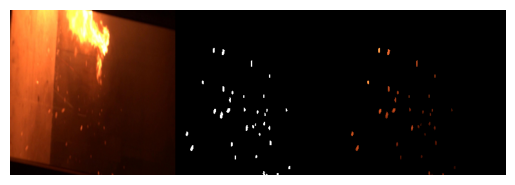

In [7]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [8]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [9]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x

  #down sampling
  f = 8
  layers = []

  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64

  #bottleneck
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  #upsampling
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1


  #classification
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #model creation
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])

  return model

  model = unet()

# Callbacks

In [10]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'/content/drive/MyDrive/firebrandDetection/images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        #predict the mask
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1
        msk[msk < 0.5] = 0

        #show the mask and the segmented image
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Traning

In [11]:
model = unet()
print(f"Model learning rate is: {K.get_value(model.optimizer.lr):.3f}")


Model learning rate is: 0.001


148.png
171.png
144.png
173.png
18.png
Epoch 1/100
169.png
164.png
95.png
172.png
93.png
 1/38 [..............................] - ETA: 5:09 - loss: 0.7648 - mean_iou: 0.0058115.png
110.png
69.png
187.png
45.png
159.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.7360 - mean_iou: 0.005271.png
196.png
73.png
26.png
177.png
 3/38 [=>............................] - ETA: 1:03 - loss: 0.7188 - mean_iou: 0.0048105.png
95.png
181.png
59.png
89.png
67.png
107.png
 4/38 [==>...........................] - ETA: 1:02 - loss: 0.7063 - mean_iou: 0.003982.png
95.png
69.png
134.png
148.png
 5/38 [==>...........................] - ETA: 1:05 - loss: 0.6956 - mean_iou: 0.0031147.png
98.png
81.png
50.png
121.png
36.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.6853 - mean_iou: 0.0026181.png
191.png
14.png
7.png
52.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.6717 - mean_iou: 0.0022197.png
27.png
131.png
57.png
 8/38 [=====>........................] - 

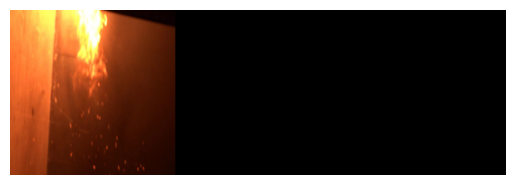

38/38 [==============================] - 89s 2s/step - loss: 0.2091 - mean_iou: 4.0677e-04 - val_loss: 0.0421 - val_mean_iou: 0.0000e+00
Epoch 2/100
112.png
137.png
36.png
74.png
162.png
 1/38 [..............................] - ETA: 1:09 - loss: 0.0327 - mean_iou: 0.0000e+00162.png
76.png
37.png
157.png
13.png
 2/38 [>.............................] - ETA: 1:00 - loss: 0.0386 - mean_iou: 0.0000e+00157.png
143.png
19.png
57.png
103.png
 3/38 [=>............................] - ETA: 58s - loss: 0.0388 - mean_iou: 0.0000e+00 127.png
105.png
20.png
199.png
86.png
 4/38 [==>...........................] - ETA: 56s - loss: 0.0406 - mean_iou: 0.0000e+00163.png
91.png
19.png
49.png
46.png
 5/38 [==>...........................] - ETA: 55s - loss: 0.0380 - mean_iou: 0.0000e+0088.png
24.png
3.png
41.png
23.png
 6/38 [===>..........................] - ETA: 53s - loss: 0.0379 - mean_iou: 0.0000e+00124.png
3.png
64.png
9.png
42.png
 7/38 [====>.........................] - ETA: 56s - loss: 0.0397 - mean

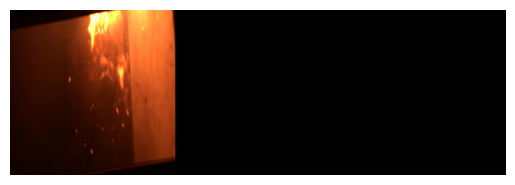

38/38 [==============================] - 78s 2s/step - loss: 0.0386 - mean_iou: 0.0000e+00 - val_loss: 0.0335 - val_mean_iou: 0.0000e+00
Epoch 3/100
173.png
52.png
7.png
44.png
54.png
 1/38 [..............................] - ETA: 1:08 - loss: 0.0348 - mean_iou: 0.0000e+0096.png
103.png
137.png
12.png
65.png
 2/38 [>.............................] - ETA: 1:01 - loss: 0.0338 - mean_iou: 0.0000e+00114.png
174.png
117.png
142.png
129.png
 3/38 [=>............................] - ETA: 1:15 - loss: 0.0348 - mean_iou: 0.0000e+00198.png
121.png
110.png
114.png
191.png
 4/38 [==>...........................] - ETA: 1:17 - loss: 0.0340 - mean_iou: 0.0000e+0020.png
55.png
63.png
133.png
186.png
 5/38 [==>...........................] - ETA: 1:10 - loss: 0.0349 - mean_iou: 0.0000e+0061.png
164.png
49.png
175.png
37.png
 6/38 [===>..........................] - ETA: 1:06 - loss: 0.0373 - mean_iou: 0.0000e+00108.png
130.png
89.png
95.png
112.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 

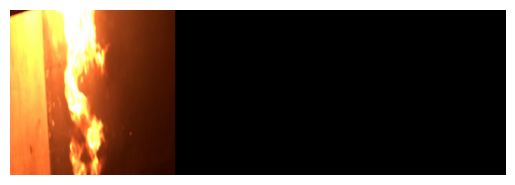

38/38 [==============================] - 80s 2s/step - loss: 0.0367 - mean_iou: 0.0000e+00 - val_loss: 0.0236 - val_mean_iou: 0.0000e+00
Epoch 4/100
132.png
183.png
8.png
143.png
69.png
 1/38 [..............................] - ETA: 1:05 - loss: 0.0347 - mean_iou: 0.0000e+0045.png
119.png
46.png
123.png
89.png
 2/38 [>.............................] - ETA: 1:03 - loss: 0.0372 - mean_iou: 0.0000e+0052.png
148.png
108.png
129.png
22.png
 3/38 [=>............................] - ETA: 1:02 - loss: 0.0381 - mean_iou: 0.0000e+00159.png
137.png
74.png
142.png
168.png
 4/38 [==>...........................] - ETA: 1:00 - loss: 0.0370 - mean_iou: 0.0000e+00161.png
45.png
24.png
57.png
126.png
 5/38 [==>...........................] - ETA: 58s - loss: 0.0384 - mean_iou: 0.0000e+00 102.png
186.png
31.png
114.png
38.png
 6/38 [===>..........................] - ETA: 1:03 - loss: 0.0386 - mean_iou: 0.0000e+0086.png
30.png
164.png
52.png
22.png
 7/38 [====>.........................] - ETA: 1:03 - loss: 0.

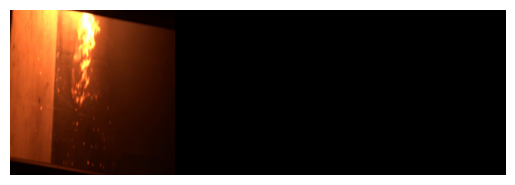

38/38 [==============================] - 78s 2s/step - loss: 0.0355 - mean_iou: 0.0000e+00 - val_loss: 0.0286 - val_mean_iou: 0.0000e+00
Epoch 5/100
40.png
69.png
136.png
189.png
13.png
 1/38 [..............................] - ETA: 1:06 - loss: 0.0322 - mean_iou: 0.0000e+00114.png
111.png
37.png
45.png
17.png
 2/38 [>.............................] - ETA: 1:19 - loss: 0.0299 - mean_iou: 0.0000e+0055.png
104.png
156.png
163.png
95.png
 3/38 [=>............................] - ETA: 1:28 - loss: 0.0310 - mean_iou: 0.0000e+00117.png
121.png
82.png
4.png
47.png
 4/38 [==>...........................] - ETA: 1:17 - loss: 0.0316 - mean_iou: 0.0000e+0080.png
60.png
106.png
56.png
177.png
 5/38 [==>...........................] - ETA: 1:10 - loss: 0.0331 - mean_iou: 0.0000e+00189.png
26.png
25.png
169.png
138.png
 6/38 [===>..........................] - ETA: 1:06 - loss: 0.0321 - mean_iou: 0.0000e+0088.png
19.png
89.png
50.png
35.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0326

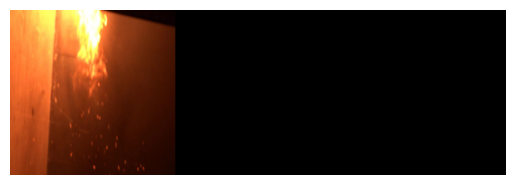

38/38 [==============================] - 80s 2s/step - loss: 0.0341 - mean_iou: 0.0000e+00 - val_loss: 0.0350 - val_mean_iou: 0.0000e+00
Epoch 6/100
193.png
49.png
180.png
18.png
196.png
 1/38 [..............................] - ETA: 1:04 - loss: 0.0364 - mean_iou: 0.0000e+0036.png
159.png
93.png
11.png
23.png
 2/38 [>.............................] - ETA: 1:02 - loss: 0.0404 - mean_iou: 0.0000e+00104.png
162.png
124.png
30.png
64.png
 3/38 [=>............................] - ETA: 1:00 - loss: 0.0370 - mean_iou: 0.0000e+0036.png
59.png
86.png
141.png
142.png
 4/38 [==>...........................] - ETA: 58s - loss: 0.0349 - mean_iou: 0.0000e+00 12.png
141.png
56.png
47.png
166.png
 5/38 [==>...........................] - ETA: 58s - loss: 0.0331 - mean_iou: 0.0000e+006.png
156.png
121.png
40.png
31.png
 6/38 [===>..........................] - ETA: 1:04 - loss: 0.0338 - mean_iou: 0.0000e+0086.png
143.png
116.png
45.png
132.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.033

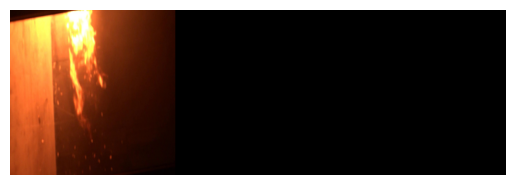

38/38 [==============================] - 77s 2s/step - loss: 0.0326 - mean_iou: 0.0000e+00 - val_loss: 0.0344 - val_mean_iou: 0.0000e+00
Epoch 7/100
23.png
6.png
142.png
174.png
126.png
 1/38 [..............................] - ETA: 1:04 - loss: 0.0378 - mean_iou: 0.0000e+00149.png
93.png
117.png
74.png
142.png
 2/38 [>.............................] - ETA: 1:11 - loss: 0.0344 - mean_iou: 0.0000e+0035.png
188.png
124.png
90.png
109.png
 3/38 [=>............................] - ETA: 1:27 - loss: 0.0345 - mean_iou: 0.0000e+00172.png
83.png
188.png
192.png
8.png
 4/38 [==>...........................] - ETA: 1:18 - loss: 0.0338 - mean_iou: 0.0000e+0084.png
108.png
103.png
116.png
153.png
 5/38 [==>...........................] - ETA: 1:11 - loss: 0.0351 - mean_iou: 0.0000e+0092.png
187.png
121.png
180.png
77.png
 6/38 [===>..........................] - ETA: 1:07 - loss: 0.0366 - mean_iou: 0.0000e+0032.png
76.png
49.png
190.png
101.png
 7/38 [====>.........................] - ETA: 1:03 - loss: 

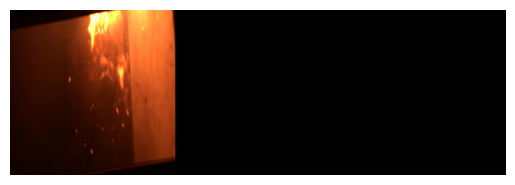

38/38 [==============================] - 80s 2s/step - loss: 0.0334 - mean_iou: 0.0000e+00 - val_loss: 0.0307 - val_mean_iou: 0.0000e+00
Epoch 8/100
124.png
138.png
179.png
140.png
86.png
 1/38 [..............................] - ETA: 1:06 - loss: 0.0334 - mean_iou: 0.0000e+0070.png
85.png
106.png
95.png
59.png
 2/38 [>.............................] - ETA: 1:02 - loss: 0.0371 - mean_iou: 0.0000e+0040.png
76.png
103.png
109.png
70.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0362 - mean_iou: 0.0000e+00172.png
43.png
18.png
36.png
33.png
 4/38 [==>...........................] - ETA: 1:15 - loss: 0.0364 - mean_iou: 0.0000e+00119.png
153.png
196.png
134.png
127.png
 5/38 [==>...........................] - ETA: 1:19 - loss: 0.0356 - mean_iou: 0.0000e+00128.png
140.png
25.png
22.png
103.png
 6/38 [===>..........................] - ETA: 1:17 - loss: 0.0366 - mean_iou: 0.0000e+0024.png
46.png
5.png
54.png
92.png
 7/38 [====>.........................] - ETA: 1:11 - loss: 0.03

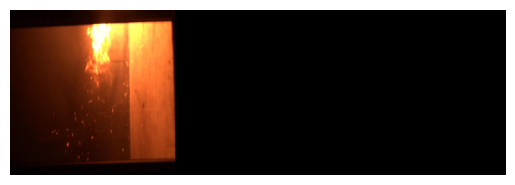

38/38 [==============================] - 80s 2s/step - loss: 0.0324 - mean_iou: 0.0000e+00 - val_loss: 0.0283 - val_mean_iou: 0.0000e+00
Epoch 9/100
97.png
3.png
22.png
165.png
191.png
 1/38 [..............................] - ETA: 1:22 - loss: 0.0242 - mean_iou: 0.0000e+00166.png
8.png
87.png
130.png
83.png
 2/38 [>.............................] - ETA: 1:42 - loss: 0.0270 - mean_iou: 0.0000e+0019.png
70.png
39.png
135.png
80.png
 3/38 [=>............................] - ETA: 1:21 - loss: 0.0269 - mean_iou: 0.0000e+00181.png
173.png
181.png
11.png
20.png
 4/38 [==>...........................] - ETA: 1:12 - loss: 0.0252 - mean_iou: 0.0000e+0096.png
69.png
122.png
96.png
135.png
 5/38 [==>...........................] - ETA: 1:06 - loss: 0.0250 - mean_iou: 0.0000e+0018.png
115.png
122.png
159.png
75.png
 6/38 [===>..........................] - ETA: 1:03 - loss: 0.0252 - mean_iou: 0.0000e+0089.png
147.png
166.png
171.png
184.png
 7/38 [====>.........................] - ETA: 59s - loss: 0.024

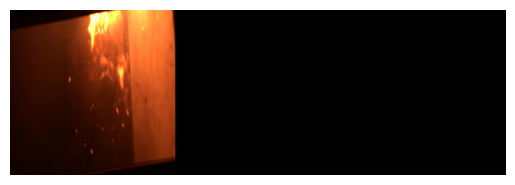

38/38 [==============================] - 80s 2s/step - loss: 0.0303 - mean_iou: 0.0000e+00 - val_loss: 0.0290 - val_mean_iou: 0.0000e+00
Epoch 10/100
183.png
81.png
165.png
135.png
132.png
 1/38 [..............................] - ETA: 1:07 - loss: 0.0261 - mean_iou: 0.0000e+00108.png
32.png
192.png
79.png
164.png
 2/38 [>.............................] - ETA: 1:02 - loss: 0.0334 - mean_iou: 0.0000e+00125.png
12.png
78.png
153.png
120.png
 3/38 [=>............................] - ETA: 1:00 - loss: 0.0323 - mean_iou: 0.0000e+0051.png
43.png
121.png
92.png
67.png
 4/38 [==>...........................] - ETA: 1:01 - loss: 0.0317 - mean_iou: 0.0000e+0064.png
52.png
9.png
120.png
103.png
 5/38 [==>...........................] - ETA: 1:08 - loss: 0.0319 - mean_iou: 0.0000e+00199.png
149.png
70.png
119.png
91.png
 6/38 [===>..........................] - ETA: 1:05 - loss: 0.0309 - mean_iou: 0.0000e+00149.png
103.png
188.png
46.png
50.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 

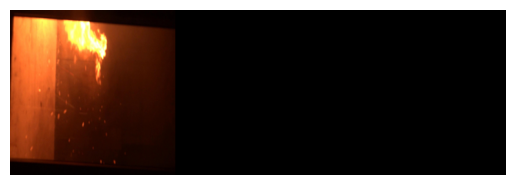

38/38 [==============================] - 78s 2s/step - loss: 0.0307 - mean_iou: 0.0000e+00 - val_loss: 0.0287 - val_mean_iou: 0.0000e+00
Epoch 11/100
200.png
27.png
20.png
52.png
197.png
 1/38 [..............................] - ETA: 1:44 - loss: 0.0295 - mean_iou: 0.0000e+0048.png
88.png
1.png
158.png
69.png
 2/38 [>.............................] - ETA: 1:23 - loss: 0.0280 - mean_iou: 0.0000e+003.png
123.png
27.png
192.png
18.png
 3/38 [=>............................] - ETA: 1:10 - loss: 0.0277 - mean_iou: 0.0000e+0056.png
144.png
173.png
72.png
75.png
 4/38 [==>...........................] - ETA: 1:04 - loss: 0.0280 - mean_iou: 0.0000e+00174.png
60.png
27.png
47.png
91.png
 5/38 [==>...........................] - ETA: 1:01 - loss: 0.0273 - mean_iou: 0.0000e+00118.png
180.png
192.png
130.png
159.png
 6/38 [===>..........................] - ETA: 58s - loss: 0.0274 - mean_iou: 0.0000e+00 199.png
183.png
161.png
61.png
148.png
 7/38 [====>.........................] - ETA: 56s - loss: 0.02

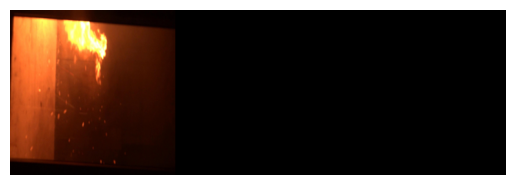

38/38 [==============================] - 80s 2s/step - loss: 0.0284 - mean_iou: 0.0000e+00 - val_loss: 0.0234 - val_mean_iou: 0.0000e+00
Epoch 12/100
111.png
90.png
23.png
195.png
119.png
 1/38 [..............................] - ETA: 1:07 - loss: 0.0331 - mean_iou: 0.0000e+0082.png
13.png
56.png
37.png
174.png
 2/38 [>.............................] - ETA: 1:01 - loss: 0.0310 - mean_iou: 0.0000e+00157.png
136.png
25.png
79.png
171.png
 3/38 [=>............................] - ETA: 1:01 - loss: 0.0302 - mean_iou: 0.0000e+0073.png
189.png
153.png
177.png
100.png
 4/38 [==>...........................] - ETA: 1:03 - loss: 0.0319 - mean_iou: 0.0000e+00156.png
78.png
55.png
146.png
40.png
 5/38 [==>...........................] - ETA: 1:10 - loss: 0.0299 - mean_iou: 0.0000e+00100.png
121.png
102.png
84.png
72.png
 6/38 [===>..........................] - ETA: 1:07 - loss: 0.0301 - mean_iou: 0.0000e+00168.png
141.png
109.png
144.png
175.png
 7/38 [====>.........................] - ETA: 1:03 - los

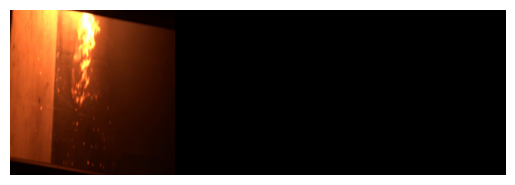

38/38 [==============================] - 79s 2s/step - loss: 0.0262 - mean_iou: 0.0000e+00 - val_loss: 0.0232 - val_mean_iou: 0.0000e+00
Epoch 13/100
173.png
85.png
131.png
26.png
159.png
 1/38 [..............................] - ETA: 1:52 - loss: 0.0305 - mean_iou: 0.0000e+0091.png
129.png
110.png
37.png
159.png
 2/38 [>.............................] - ETA: 1:14 - loss: 0.0298 - mean_iou: 0.0000e+00110.png
115.png
48.png
21.png
128.png
 3/38 [=>............................] - ETA: 1:08 - loss: 0.0358 - mean_iou: 0.0000e+00186.png
1.png
15.png
115.png
119.png
 4/38 [==>...........................] - ETA: 1:04 - loss: 0.0341 - mean_iou: 0.0000e+00146.png
48.png
70.png
3.png
130.png
 5/38 [==>...........................] - ETA: 1:01 - loss: 0.0324 - mean_iou: 0.0000e+00147.png
84.png
168.png
146.png
109.png
 6/38 [===>..........................] - ETA: 59s - loss: 0.0322 - mean_iou: 0.0000e+00 45.png
153.png
107.png
200.png
79.png
 7/38 [====>.........................] - ETA: 57s - loss: 

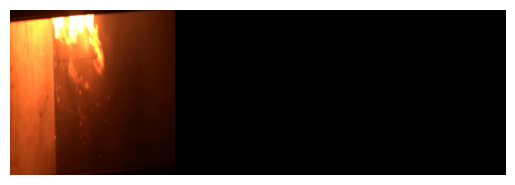

38/38 [==============================] - 85s 2s/step - loss: 0.0264 - mean_iou: 0.0000e+00 - val_loss: 0.0221 - val_mean_iou: 0.0000e+00
Epoch 14/100
102.png
60.png
199.png
18.png
187.png
 1/38 [..............................] - ETA: 1:05 - loss: 0.0251 - mean_iou: 0.0000e+0050.png
44.png
55.png
186.png
77.png
 2/38 [>.............................] - ETA: 1:12 - loss: 0.0275 - mean_iou: 0.0000e+00193.png
81.png
71.png
184.png
63.png
 3/38 [=>............................] - ETA: 1:25 - loss: 0.0254 - mean_iou: 0.0000e+0051.png
42.png
60.png
124.png
19.png
 4/38 [==>...........................] - ETA: 1:18 - loss: 0.0247 - mean_iou: 0.0000e+00139.png
117.png
177.png
87.png
151.png
 5/38 [==>...........................] - ETA: 1:11 - loss: 0.0242 - mean_iou: 0.0000e+0093.png
82.png
23.png
105.png
1.png
 6/38 [===>..........................] - ETA: 1:06 - loss: 0.0247 - mean_iou: 0.0000e+0051.png
199.png
1.png
5.png
33.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0243 -

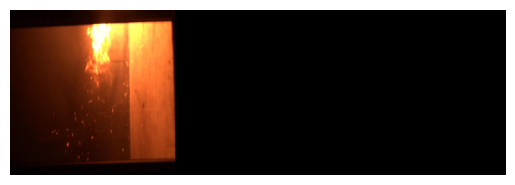

38/38 [==============================] - 79s 2s/step - loss: 0.0222 - mean_iou: 0.0000e+00 - val_loss: 0.0143 - val_mean_iou: 0.0000e+00
Epoch 15/100
133.png
197.png
97.png
5.png
16.png
 1/38 [..............................] - ETA: 1:08 - loss: 0.0096 - mean_iou: 0.0000e+0016.png
47.png
89.png
43.png
31.png
 2/38 [>.............................] - ETA: 1:04 - loss: 0.0182 - mean_iou: 0.0000e+0018.png
167.png
24.png
195.png
141.png
 3/38 [=>............................] - ETA: 1:02 - loss: 0.0212 - mean_iou: 0.0000e+00105.png
93.png
83.png
11.png
16.png
 4/38 [==>...........................] - ETA: 1:00 - loss: 0.0240 - mean_iou: 0.0000e+0024.png
93.png
117.png
164.png
4.png
 5/38 [==>...........................] - ETA: 58s - loss: 0.0224 - mean_iou: 0.0000e+00 93.png
133.png
190.png
40.png
200.png
 6/38 [===>..........................] - ETA: 1:00 - loss: 0.0214 - mean_iou: 0.0000e+0048.png
21.png
151.png
119.png
162.png
 7/38 [====>.........................] - ETA: 1:03 - loss: 0.0206

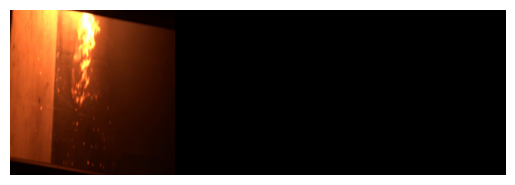

38/38 [==============================] - 78s 2s/step - loss: 0.0191 - mean_iou: 0.0000e+00 - val_loss: 0.0187 - val_mean_iou: 0.0000e+00
Epoch 16/100
140.png
97.png
74.png
83.png
189.png
 1/38 [..............................] - ETA: 1:06 - loss: 0.0142 - mean_iou: 0.0000e+00144.png
68.png
174.png
68.png
105.png
 2/38 [>.............................] - ETA: 1:03 - loss: 0.0170 - mean_iou: 0.0000e+0093.png
195.png
76.png
68.png
199.png
 3/38 [=>............................] - ETA: 1:20 - loss: 0.0186 - mean_iou: 0.0000e+0075.png
183.png
104.png
13.png
163.png
 4/38 [==>...........................] - ETA: 1:28 - loss: 0.0188 - mean_iou: 0.0000e+00153.png
144.png
100.png
184.png
104.png
 5/38 [==>...........................] - ETA: 1:26 - loss: 0.0200 - mean_iou: 0.0000e+0064.png
19.png
9.png
149.png
98.png
 6/38 [===>..........................] - ETA: 1:18 - loss: 0.0198 - mean_iou: 0.0000e+00167.png
120.png
124.png
156.png
39.png
 7/38 [====>.........................] - ETA: 1:12 - loss:

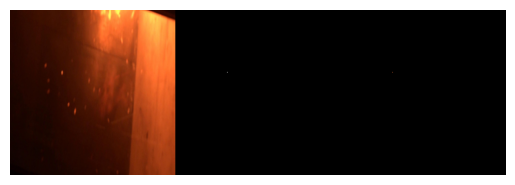

38/38 [==============================] - 80s 2s/step - loss: 0.0177 - mean_iou: 8.4537e-05 - val_loss: 0.0126 - val_mean_iou: 0.0054
Epoch 17/100
188.png
15.png
3.png
30.png
48.png
 1/38 [..............................] - ETA: 1:43 - loss: 0.0108 - mean_iou: 0.0055120.png
169.png
116.png
179.png
110.png
 2/38 [>.............................] - ETA: 1:08 - loss: 0.0122 - mean_iou: 0.00334.png
55.png
80.png
16.png
145.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0118 - mean_iou: 0.0022128.png
107.png
29.png
101.png
150.png
 4/38 [==>...........................] - ETA: 1:01 - loss: 0.0111 - mean_iou: 0.002166.png
170.png
151.png
111.png
103.png
 5/38 [==>...........................] - ETA: 59s - loss: 0.0126 - mean_iou: 0.0024 105.png
166.png
24.png
116.png
124.png
 6/38 [===>..........................] - ETA: 56s - loss: 0.0127 - mean_iou: 0.003768.png
63.png
189.png
12.png
35.png
 7/38 [====>.........................] - ETA: 56s - loss: 0.0144 - mean_iou: 0.0033142.p

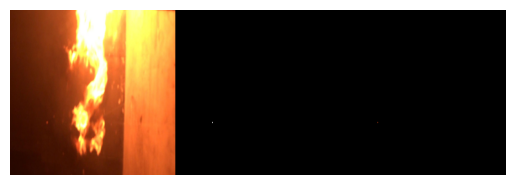

38/38 [==============================] - 79s 2s/step - loss: 0.0164 - mean_iou: 0.0110 - val_loss: 0.0115 - val_mean_iou: 0.0490
Epoch 18/100
11.png
166.png
196.png
18.png
52.png
 1/38 [..............................] - ETA: 1:06 - loss: 0.0176 - mean_iou: 0.0486106.png
56.png
196.png
122.png
21.png
 2/38 [>.............................] - ETA: 1:01 - loss: 0.0174 - mean_iou: 0.02466.png
69.png
162.png
138.png
85.png
 3/38 [=>............................] - ETA: 1:00 - loss: 0.0153 - mean_iou: 0.0206138.png
19.png
79.png
44.png
71.png
 4/38 [==>...........................] - ETA: 1:00 - loss: 0.0137 - mean_iou: 0.016012.png
107.png
198.png
174.png
98.png
 5/38 [==>...........................] - ETA: 1:07 - loss: 0.0142 - mean_iou: 0.0151147.png
81.png
57.png
132.png
92.png
 6/38 [===>..........................] - ETA: 1:06 - loss: 0.0141 - mean_iou: 0.0174177.png
154.png
39.png
161.png
14.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0143 - mean_iou: 0.015482.png
118

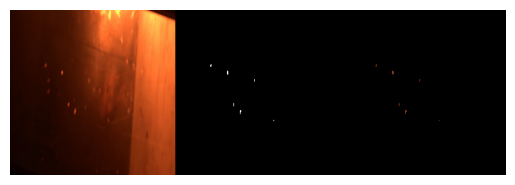

38/38 [==============================] - 80s 2s/step - loss: 0.0143 - mean_iou: 0.0456 - val_loss: 0.0113 - val_mean_iou: 0.0729
Epoch 19/100
68.png
78.png
119.png
87.png
25.png
 1/38 [..............................] - ETA: 1:46 - loss: 0.0122 - mean_iou: 0.0774109.png
198.png
10.png
33.png
151.png
 2/38 [>.............................] - ETA: 1:04 - loss: 0.0156 - mean_iou: 0.0977121.png
158.png
67.png
179.png
168.png
 3/38 [=>............................] - ETA: 1:02 - loss: 0.0155 - mean_iou: 0.0926159.png
86.png
7.png
4.png
189.png
 4/38 [==>...........................] - ETA: 1:00 - loss: 0.0162 - mean_iou: 0.0944172.png
98.png
108.png
26.png
189.png
 5/38 [==>...........................] - ETA: 59s - loss: 0.0155 - mean_iou: 0.0951 146.png
115.png
3.png
193.png
158.png
 6/38 [===>..........................] - ETA: 56s - loss: 0.0149 - mean_iou: 0.098378.png
142.png
183.png
35.png
102.png
 7/38 [====>.........................] - ETA: 57s - loss: 0.0141 - mean_iou: 0.0891179.png
18

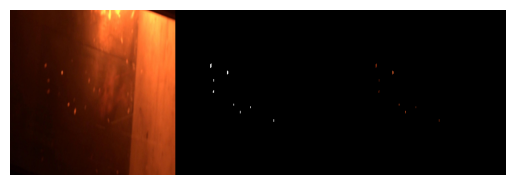

38/38 [==============================] - 79s 2s/step - loss: 0.0136 - mean_iou: 0.1229 - val_loss: 0.0140 - val_mean_iou: 0.1417
Epoch 20/100
139.png
150.png
128.png
58.png
49.png
 1/38 [..............................] - ETA: 1:07 - loss: 0.0172 - mean_iou: 0.117188.png
81.png
30.png
188.png
138.png
 2/38 [>.............................] - ETA: 1:02 - loss: 0.0197 - mean_iou: 0.088870.png
17.png
84.png
36.png
142.png
 3/38 [=>............................] - ETA: 1:01 - loss: 0.0179 - mean_iou: 0.140386.png
89.png
39.png
18.png
183.png
 4/38 [==>...........................] - ETA: 1:11 - loss: 0.0172 - mean_iou: 0.12041.png
14.png
89.png
84.png
23.png
 5/38 [==>...........................] - ETA: 1:12 - loss: 0.0162 - mean_iou: 0.140997.png
34.png
87.png
7.png
59.png
 6/38 [===>..........................] - ETA: 1:07 - loss: 0.0152 - mean_iou: 0.1481168.png
102.png
103.png
181.png
104.png
 7/38 [====>.........................] - ETA: 1:03 - loss: 0.0145 - mean_iou: 0.150176.png
134.png


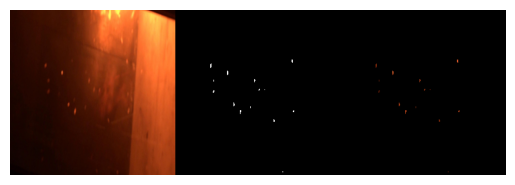

38/38 [==============================] - 79s 2s/step - loss: 0.0131 - mean_iou: 0.1863 - val_loss: 0.0099 - val_mean_iou: 0.2043
Epoch 21/100
122.png
30.png
85.png
82.png
146.png
 1/38 [..............................] - ETA: 1:44 - loss: 0.0123 - mean_iou: 0.1532171.png
13.png
119.png
57.png
139.png
 2/38 [>.............................] - ETA: 1:13 - loss: 0.0129 - mean_iou: 0.248054.png
96.png
11.png
161.png
37.png
 3/38 [=>............................] - ETA: 1:06 - loss: 0.0137 - mean_iou: 0.2236111.png
101.png
83.png
11.png
124.png
 4/38 [==>...........................] - ETA: 1:03 - loss: 0.0138 - mean_iou: 0.231810.png
94.png
25.png
105.png
12.png
 5/38 [==>...........................] - ETA: 1:00 - loss: 0.0150 - mean_iou: 0.2196162.png
87.png
63.png
46.png
53.png
 6/38 [===>..........................] - ETA: 58s - loss: 0.0142 - mean_iou: 0.2382 76.png
134.png
47.png
177.png
170.png
 7/38 [====>.........................] - ETA: 56s - loss: 0.0148 - mean_iou: 0.22059.png
175.pn

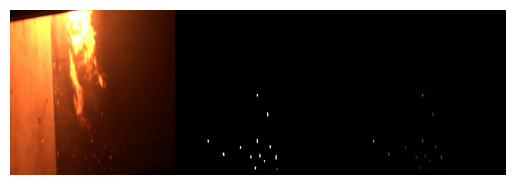

38/38 [==============================] - 82s 2s/step - loss: 0.0127 - mean_iou: 0.2478 - val_loss: 0.0104 - val_mean_iou: 0.3153
Epoch 22/100
1.png
156.png
103.png
154.png
115.png
 1/38 [..............................] - ETA: 1:06 - loss: 0.0084 - mean_iou: 0.2637173.png
59.png
15.png
140.png
31.png
 2/38 [>.............................] - ETA: 1:01 - loss: 0.0086 - mean_iou: 0.262337.png
138.png
49.png
27.png
163.png
 3/38 [=>............................] - ETA: 59s - loss: 0.0092 - mean_iou: 0.2781 57.png
29.png
24.png
134.png
21.png
 4/38 [==>...........................] - ETA: 1:10 - loss: 0.0097 - mean_iou: 0.2657163.png
32.png
58.png
165.png
187.png
 5/38 [==>...........................] - ETA: 1:11 - loss: 0.0100 - mean_iou: 0.2806128.png
120.png
163.png
190.png
133.png
 6/38 [===>..........................] - ETA: 1:06 - loss: 0.0099 - mean_iou: 0.287852.png
117.png
160.png
128.png
24.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0095 - mean_iou: 0.302547.png

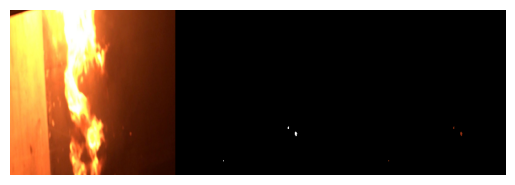

38/38 [==============================] - 79s 2s/step - loss: 0.0111 - mean_iou: 0.3226 - val_loss: 0.0082 - val_mean_iou: 0.4374
Epoch 23/100
186.png
83.png
105.png
100.png
100.png
 1/38 [..............................] - ETA: 1:51 - loss: 0.0099 - mean_iou: 0.3526180.png
13.png
107.png
53.png
165.png
 2/38 [>.............................] - ETA: 1:09 - loss: 0.0100 - mean_iou: 0.390110.png
174.png
79.png
88.png
132.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0098 - mean_iou: 0.361885.png
125.png
198.png
92.png
43.png
 4/38 [==>...........................] - ETA: 1:00 - loss: 0.0114 - mean_iou: 0.352091.png
95.png
129.png
106.png
143.png
 5/38 [==>...........................] - ETA: 58s - loss: 0.0116 - mean_iou: 0.3440 54.png
18.png
64.png
68.png
114.png
 6/38 [===>..........................] - ETA: 56s - loss: 0.0114 - mean_iou: 0.3399150.png
71.png
150.png
55.png
50.png
 7/38 [====>.........................] - ETA: 56s - loss: 0.0111 - mean_iou: 0.347037.png
68.

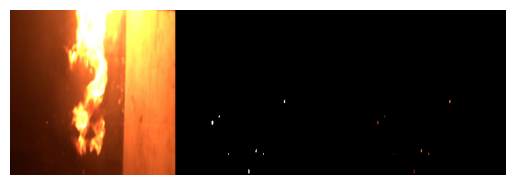

38/38 [==============================] - 81s 2s/step - loss: 0.0112 - mean_iou: 0.3777 - val_loss: 0.0078 - val_mean_iou: 0.4659
Epoch 24/100
151.png
164.png
186.png
45.png
13.png
 1/38 [..............................] - ETA: 1:48 - loss: 0.0121 - mean_iou: 0.419088.png
79.png
20.png
160.png
125.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0101 - mean_iou: 0.4407176.png
193.png
25.png
192.png
16.png
 3/38 [=>............................] - ETA: 1:21 - loss: 0.0090 - mean_iou: 0.4702103.png
24.png
149.png
128.png
36.png
 4/38 [==>...........................] - ETA: 1:21 - loss: 0.0089 - mean_iou: 0.4500174.png
78.png
61.png
153.png
143.png
 5/38 [==>...........................] - ETA: 1:13 - loss: 0.0090 - mean_iou: 0.439057.png
134.png
68.png
23.png
40.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0092 - mean_iou: 0.437043.png
132.png
48.png
140.png
141.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0098 - mean_iou: 0.414787.png


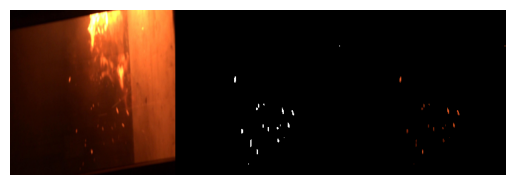

38/38 [==============================] - 83s 2s/step - loss: 0.0106 - mean_iou: 0.4185 - val_loss: 0.0070 - val_mean_iou: 0.5107
Epoch 25/100
184.png
142.png
160.png
4.png
106.png
 1/38 [..............................] - ETA: 1:08 - loss: 0.0124 - mean_iou: 0.4518142.png
200.png
169.png
86.png
135.png
 2/38 [>.............................] - ETA: 1:05 - loss: 0.0133 - mean_iou: 0.449935.png
200.png
27.png
98.png
27.png
 3/38 [=>............................] - ETA: 1:03 - loss: 0.0136 - mean_iou: 0.4612158.png
20.png
15.png
101.png
137.png
 4/38 [==>...........................] - ETA: 1:01 - loss: 0.0127 - mean_iou: 0.4383188.png
40.png
184.png
135.png
117.png
 5/38 [==>...........................] - ETA: 1:03 - loss: 0.0120 - mean_iou: 0.453720.png
84.png
148.png
101.png
107.png
 6/38 [===>..........................] - ETA: 1:07 - loss: 0.0117 - mean_iou: 0.445177.png
153.png
3.png
123.png
91.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0115 - mean_iou: 0.4533127.pn

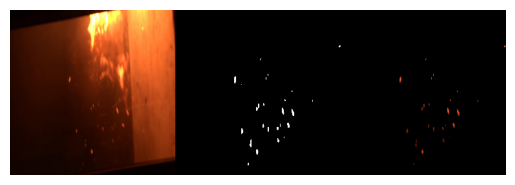

38/38 [==============================] - 80s 2s/step - loss: 0.0110 - mean_iou: 0.4186 - val_loss: 0.0078 - val_mean_iou: 0.5258
Epoch 26/100
124.png
176.png
81.png
19.png
122.png
 1/38 [..............................] - ETA: 1:16 - loss: 0.0123 - mean_iou: 0.491687.png
133.png
160.png
58.png
184.png
 2/38 [>.............................] - ETA: 1:40 - loss: 0.0096 - mean_iou: 0.476616.png
165.png
169.png
85.png
88.png
 3/38 [=>............................] - ETA: 1:26 - loss: 0.0106 - mean_iou: 0.4197199.png
146.png
144.png
196.png
192.png
 4/38 [==>...........................] - ETA: 1:16 - loss: 0.0117 - mean_iou: 0.436947.png
11.png
44.png
199.png
73.png
 5/38 [==>...........................] - ETA: 1:10 - loss: 0.0120 - mean_iou: 0.4091171.png
15.png
196.png
51.png
170.png
 6/38 [===>..........................] - ETA: 1:06 - loss: 0.0113 - mean_iou: 0.4126144.png
50.png
74.png
57.png
105.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0110 - mean_iou: 0.403224.png

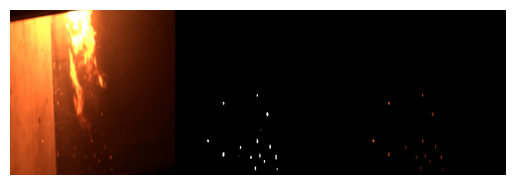

38/38 [==============================] - 84s 2s/step - loss: 0.0105 - mean_iou: 0.4292 - val_loss: 0.0091 - val_mean_iou: 0.4432
Epoch 27/100
91.png
12.png
73.png
63.png
64.png
 1/38 [..............................] - ETA: 1:08 - loss: 0.0083 - mean_iou: 0.3944164.png
190.png
109.png
163.png
77.png
 2/38 [>.............................] - ETA: 1:04 - loss: 0.0080 - mean_iou: 0.43685.png
145.png
98.png
60.png
49.png
 3/38 [=>............................] - ETA: 1:03 - loss: 0.0104 - mean_iou: 0.456990.png
3.png
7.png
48.png
170.png
 4/38 [==>...........................] - ETA: 1:01 - loss: 0.0102 - mean_iou: 0.470639.png
59.png
179.png
17.png
150.png
 5/38 [==>...........................] - ETA: 1:09 - loss: 0.0101 - mean_iou: 0.4549171.png
40.png
142.png
48.png
97.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0096 - mean_iou: 0.4671167.png
9.png
72.png
78.png
88.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0090 - mean_iou: 0.4648175.png
163.png
15

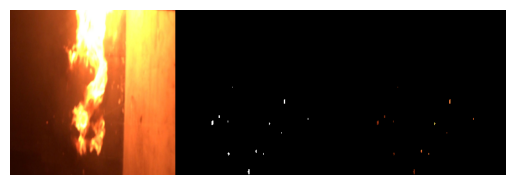

38/38 [==============================] - 80s 2s/step - loss: 0.0097 - mean_iou: 0.4759 - val_loss: 0.0085 - val_mean_iou: 0.5954
Epoch 28/100
180.png
10.png
20.png
175.png
160.png
 1/38 [..............................] - ETA: 1:48 - loss: 0.0117 - mean_iou: 0.4226109.png
199.png
160.png
139.png
195.png
 2/38 [>.............................] - ETA: 1:28 - loss: 0.0122 - mean_iou: 0.459374.png
56.png
30.png
146.png
29.png
 3/38 [=>............................] - ETA: 1:14 - loss: 0.0104 - mean_iou: 0.4293169.png
16.png
180.png
169.png
54.png
 4/38 [==>...........................] - ETA: 1:08 - loss: 0.0095 - mean_iou: 0.446524.png
133.png
19.png
48.png
2.png
 5/38 [==>...........................] - ETA: 1:05 - loss: 0.0103 - mean_iou: 0.44432.png
75.png
12.png
45.png
192.png
 6/38 [===>..........................] - ETA: 1:01 - loss: 0.0100 - mean_iou: 0.465670.png
184.png
87.png
95.png
71.png
 7/38 [====>.........................] - ETA: 59s - loss: 0.0096 - mean_iou: 0.4547 146.png
148.

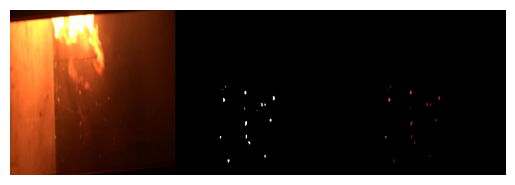

38/38 [==============================] - 80s 2s/step - loss: 0.0090 - mean_iou: 0.4630 - val_loss: 0.0075 - val_mean_iou: 0.5537
Epoch 29/100
61.png
168.png
156.png
86.png
75.png
 1/38 [..............................] - ETA: 1:07 - loss: 0.0090 - mean_iou: 0.4713117.png
68.png
82.png
72.png
38.png
 2/38 [>.............................] - ETA: 1:04 - loss: 0.0089 - mean_iou: 0.4787105.png
133.png
76.png
190.png
89.png
 3/38 [=>............................] - ETA: 1:02 - loss: 0.0087 - mean_iou: 0.484397.png
36.png
125.png
198.png
108.png
 4/38 [==>...........................] - ETA: 1:02 - loss: 0.0081 - mean_iou: 0.485351.png
158.png
95.png
81.png
196.png
 5/38 [==>...........................] - ETA: 1:11 - loss: 0.0089 - mean_iou: 0.462197.png
3.png
65.png
100.png
115.png
 6/38 [===>..........................] - ETA: 1:16 - loss: 0.0096 - mean_iou: 0.47011.png
136.png
21.png
11.png
39.png
 7/38 [====>.........................] - ETA: 1:13 - loss: 0.0096 - mean_iou: 0.462812.png
112.pn

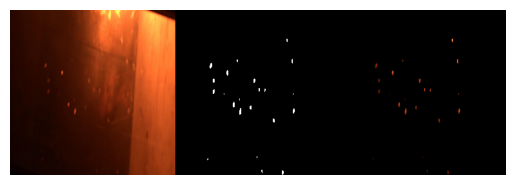

38/38 [==============================] - 81s 2s/step - loss: 0.0110 - mean_iou: 0.4783 - val_loss: 0.0056 - val_mean_iou: 0.5276
Epoch 30/100
82.png
141.png
42.png
29.png
39.png
 1/38 [..............................] - ETA: 1:46 - loss: 0.0117 - mean_iou: 0.4508120.png
191.png
108.png
2.png
37.png
 2/38 [>.............................] - ETA: 1:19 - loss: 0.0101 - mean_iou: 0.4870162.png
106.png
25.png
57.png
172.png
 3/38 [=>............................] - ETA: 1:09 - loss: 0.0091 - mean_iou: 0.498238.png
136.png
27.png
168.png
67.png
 4/38 [==>...........................] - ETA: 1:05 - loss: 0.0084 - mean_iou: 0.520583.png
154.png
20.png
51.png
42.png
 5/38 [==>...........................] - ETA: 1:01 - loss: 0.0084 - mean_iou: 0.5121132.png
195.png
125.png
123.png
67.png
 6/38 [===>..........................] - ETA: 59s - loss: 0.0086 - mean_iou: 0.5116 49.png
95.png
81.png
179.png
144.png
 7/38 [====>.........................] - ETA: 57s - loss: 0.0086 - mean_iou: 0.502558.png
74.p

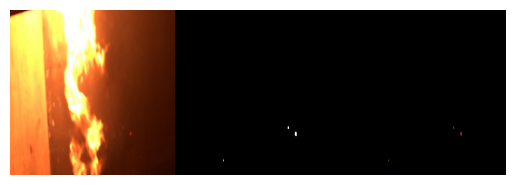

38/38 [==============================] - 81s 2s/step - loss: 0.0090 - mean_iou: 0.5014 - val_loss: 0.0076 - val_mean_iou: 0.5115
Epoch 31/100
132.png
7.png
36.png
96.png
191.png
 1/38 [..............................] - ETA: 1:07 - loss: 0.0064 - mean_iou: 0.4377184.png
165.png
3.png
104.png
49.png
 2/38 [>.............................] - ETA: 1:06 - loss: 0.0072 - mean_iou: 0.476242.png
187.png
44.png
121.png
10.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0086 - mean_iou: 0.502172.png
69.png
188.png
89.png
166.png
 4/38 [==>...........................] - ETA: 1:12 - loss: 0.0079 - mean_iou: 0.500168.png
122.png
42.png
33.png
184.png
 5/38 [==>...........................] - ETA: 1:14 - loss: 0.0080 - mean_iou: 0.506445.png
23.png
68.png
129.png
9.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0079 - mean_iou: 0.504539.png
146.png
70.png
12.png
196.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0083 - mean_iou: 0.502918.png
73.png


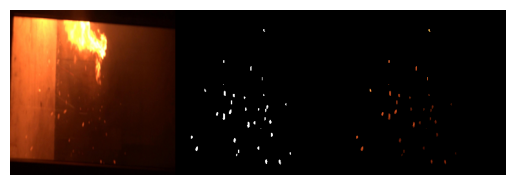

38/38 [==============================] - 84s 2s/step - loss: 0.0091 - mean_iou: 0.4900 - val_loss: 0.0084 - val_mean_iou: 0.5799
Epoch 32/100
116.png
192.png
121.png
150.png
58.png
 1/38 [..............................] - ETA: 1:09 - loss: 0.0115 - mean_iou: 0.547839.png
73.png
200.png
94.png
47.png
 2/38 [>.............................] - ETA: 1:02 - loss: 0.0112 - mean_iou: 0.476423.png
110.png
68.png
22.png
191.png
 3/38 [=>............................] - ETA: 1:02 - loss: 0.0102 - mean_iou: 0.493610.png
195.png
173.png
16.png
106.png
 4/38 [==>...........................] - ETA: 1:00 - loss: 0.0109 - mean_iou: 0.4638196.png
183.png
121.png
161.png
42.png
 5/38 [==>...........................] - ETA: 1:01 - loss: 0.0109 - mean_iou: 0.47185.png
69.png
73.png
150.png
66.png
 6/38 [===>..........................] - ETA: 1:06 - loss: 0.0108 - mean_iou: 0.473040.png
66.png
57.png
116.png
168.png
 7/38 [====>.........................] - ETA: 1:03 - loss: 0.0108 - mean_iou: 0.471911.png
91

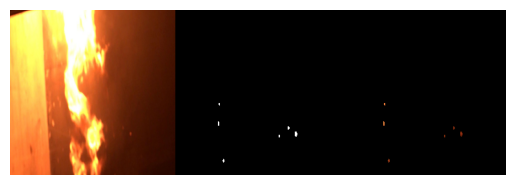

38/38 [==============================] - 81s 2s/step - loss: 0.0091 - mean_iou: 0.4987 - val_loss: 0.0085 - val_mean_iou: 0.5600
Epoch 33/100
124.png
45.png
140.png
97.png
162.png
 1/38 [..............................] - ETA: 1:29 - loss: 0.0090 - mean_iou: 0.5533159.png
72.png
109.png
193.png
66.png
 2/38 [>.............................] - ETA: 1:46 - loss: 0.0104 - mean_iou: 0.464242.png
186.png
143.png
46.png
89.png
 3/38 [=>............................] - ETA: 1:23 - loss: 0.0097 - mean_iou: 0.4779125.png
33.png
95.png
3.png
63.png
 4/38 [==>...........................] - ETA: 1:14 - loss: 0.0096 - mean_iou: 0.4769200.png
73.png
141.png
15.png
103.png
 5/38 [==>...........................] - ETA: 1:08 - loss: 0.0098 - mean_iou: 0.4885200.png
167.png
122.png
144.png
22.png
 6/38 [===>..........................] - ETA: 1:05 - loss: 0.0094 - mean_iou: 0.499496.png
33.png
131.png
38.png
72.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0087 - mean_iou: 0.5092190.png
9

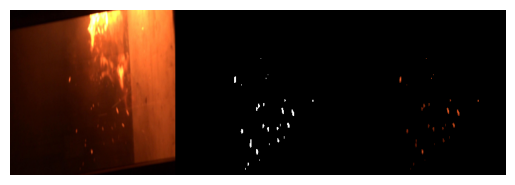

38/38 [==============================] - 81s 2s/step - loss: 0.0084 - mean_iou: 0.5197 - val_loss: 0.0058 - val_mean_iou: 0.5817
Epoch 34/100
88.png
67.png
187.png
38.png
84.png
 1/38 [..............................] - ETA: 1:08 - loss: 0.0093 - mean_iou: 0.534958.png
55.png
66.png
126.png
44.png
 2/38 [>.............................] - ETA: 1:05 - loss: 0.0107 - mean_iou: 0.5455157.png
4.png
183.png
70.png
108.png
 3/38 [=>............................] - ETA: 1:03 - loss: 0.0112 - mean_iou: 0.512991.png
1.png
136.png
101.png
169.png
 4/38 [==>...........................] - ETA: 1:03 - loss: 0.0116 - mean_iou: 0.5185132.png
69.png
137.png
22.png
64.png
 5/38 [==>...........................] - ETA: 1:10 - loss: 0.0132 - mean_iou: 0.4285179.png
80.png
134.png
154.png
43.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0124 - mean_iou: 0.4475198.png
134.png
34.png
76.png
6.png
 7/38 [====>.........................] - ETA: 1:07 - loss: 0.0118 - mean_iou: 0.458869.png
93.png

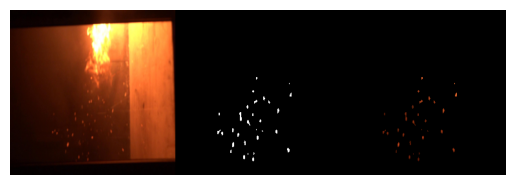

38/38 [==============================] - 85s 2s/step - loss: 0.0092 - mean_iou: 0.5135 - val_loss: 0.0082 - val_mean_iou: 0.5689
Epoch 35/100
115.png
33.png
130.png
129.png
91.png
 1/38 [..............................] - ETA: 1:10 - loss: 0.0112 - mean_iou: 0.4732138.png
8.png
146.png
71.png
173.png
 2/38 [>.............................] - ETA: 1:06 - loss: 0.0102 - mean_iou: 0.53849.png
41.png
156.png
141.png
139.png
 3/38 [=>............................] - ETA: 1:03 - loss: 0.0106 - mean_iou: 0.483151.png
117.png
156.png
59.png
188.png
 4/38 [==>...........................] - ETA: 1:01 - loss: 0.0109 - mean_iou: 0.50225.png
9.png
189.png
123.png
40.png
 5/38 [==>...........................] - ETA: 1:02 - loss: 0.0108 - mean_iou: 0.4768146.png
136.png
4.png
127.png
147.png
 6/38 [===>..........................] - ETA: 1:06 - loss: 0.0099 - mean_iou: 0.494317.png
167.png
2.png
9.png
121.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0097 - mean_iou: 0.498134.png
38.pn

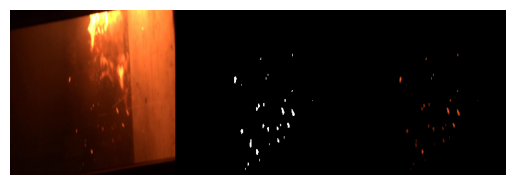

38/38 [==============================] - 79s 2s/step - loss: 0.0084 - mean_iou: 0.5088 - val_loss: 0.0085 - val_mean_iou: 0.5835
Epoch 36/100
26.png
140.png
122.png
66.png
78.png
 1/38 [..............................] - ETA: 1:07 - loss: 0.0099 - mean_iou: 0.5148183.png
10.png
119.png
153.png
166.png
 2/38 [>.............................] - ETA: 1:32 - loss: 0.0101 - mean_iou: 0.5270141.png
177.png
173.png
119.png
198.png
 3/38 [=>............................] - ETA: 1:33 - loss: 0.0109 - mean_iou: 0.4798145.png
197.png
40.png
55.png
179.png
 4/38 [==>...........................] - ETA: 1:21 - loss: 0.0114 - mean_iou: 0.4973121.png
48.png
166.png
85.png
112.png
 5/38 [==>...........................] - ETA: 1:13 - loss: 0.0107 - mean_iou: 0.494439.png
145.png
7.png
68.png
163.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0109 - mean_iou: 0.4906189.png
168.png
55.png
166.png
22.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0103 - mean_iou: 0.5045126.

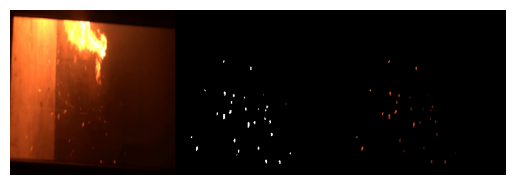

38/38 [==============================] - 83s 2s/step - loss: 0.0088 - mean_iou: 0.5184 - val_loss: 0.0057 - val_mean_iou: 0.5494
Epoch 37/100
126.png
199.png
103.png
110.png
70.png
 1/38 [..............................] - ETA: 1:06 - loss: 0.0046 - mean_iou: 0.4638131.png
33.png
31.png
84.png
67.png
 2/38 [>.............................] - ETA: 1:04 - loss: 0.0067 - mean_iou: 0.457819.png
116.png
42.png
79.png
78.png
 3/38 [=>............................] - ETA: 1:01 - loss: 0.0074 - mean_iou: 0.4850136.png
5.png
162.png
101.png
114.png
 4/38 [==>...........................] - ETA: 59s - loss: 0.0082 - mean_iou: 0.5093 159.png
81.png
122.png
4.png
171.png
 5/38 [==>...........................] - ETA: 1:07 - loss: 0.0078 - mean_iou: 0.510861.png
149.png
31.png
90.png
137.png
 6/38 [===>..........................] - ETA: 1:07 - loss: 0.0083 - mean_iou: 0.509030.png
38.png
2.png
16.png
124.png
 7/38 [====>.........................] - ETA: 1:03 - loss: 0.0085 - mean_iou: 0.514983.png
87.pn

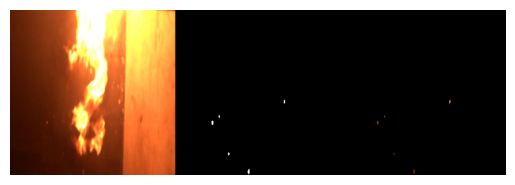

38/38 [==============================] - 79s 2s/step - loss: 0.0082 - mean_iou: 0.5193 - val_loss: 0.0066 - val_mean_iou: 0.6016
Epoch 38/100
184.png
124.png
67.png
181.png
76.png
 1/38 [..............................] - ETA: 1:06 - loss: 0.0045 - mean_iou: 0.5986190.png
157.png
51.png
76.png
195.png
 2/38 [>.............................] - ETA: 1:47 - loss: 0.0058 - mean_iou: 0.5622173.png
167.png
2.png
110.png
126.png
 3/38 [=>............................] - ETA: 1:32 - loss: 0.0058 - mean_iou: 0.5754188.png
159.png
37.png
150.png
25.png
 4/38 [==>...........................] - ETA: 1:20 - loss: 0.0064 - mean_iou: 0.559450.png
98.png
198.png
103.png
58.png
 5/38 [==>...........................] - ETA: 1:12 - loss: 0.0067 - mean_iou: 0.5579101.png
147.png
161.png
47.png
37.png
 6/38 [===>..........................] - ETA: 1:07 - loss: 0.0071 - mean_iou: 0.540116.png
15.png
71.png
12.png
160.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0072 - mean_iou: 0.54647.png
5

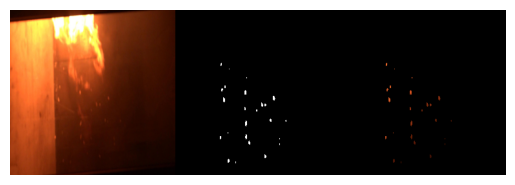

38/38 [==============================] - 81s 2s/step - loss: 0.0081 - mean_iou: 0.5290 - val_loss: 0.0062 - val_mean_iou: 0.6205
Epoch 39/100
180.png
102.png
7.png
81.png
106.png
 1/38 [..............................] - ETA: 1:09 - loss: 0.0081 - mean_iou: 0.595222.png
171.png
82.png
189.png
160.png
 2/38 [>.............................] - ETA: 1:03 - loss: 0.0078 - mean_iou: 0.5562142.png
167.png
13.png
174.png
59.png
 3/38 [=>............................] - ETA: 1:01 - loss: 0.0076 - mean_iou: 0.5649114.png
34.png
74.png
151.png
187.png
 4/38 [==>...........................] - ETA: 59s - loss: 0.0081 - mean_iou: 0.5600 48.png
146.png
58.png
168.png
101.png
 5/38 [==>...........................] - ETA: 1:02 - loss: 0.0082 - mean_iou: 0.555610.png
137.png
57.png
188.png
103.png
 6/38 [===>..........................] - ETA: 1:06 - loss: 0.0078 - mean_iou: 0.546939.png
67.png
76.png
22.png
84.png
 7/38 [====>.........................] - ETA: 1:03 - loss: 0.0081 - mean_iou: 0.551619.png
7

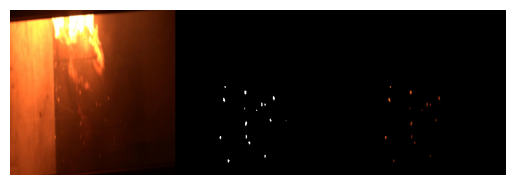

38/38 [==============================] - 81s 2s/step - loss: 0.0086 - mean_iou: 0.5337 - val_loss: 0.0072 - val_mean_iou: 0.5374
Epoch 40/100
54.png
150.png
114.png
1.png
146.png
 1/38 [..............................] - ETA: 1:49 - loss: 0.0058 - mean_iou: 0.469868.png
74.png
103.png
163.png
47.png
 2/38 [>.............................] - ETA: 1:26 - loss: 0.0078 - mean_iou: 0.498985.png
150.png
125.png
2.png
32.png
 3/38 [=>............................] - ETA: 1:14 - loss: 0.0078 - mean_iou: 0.5233163.png
142.png
138.png
73.png
154.png
 4/38 [==>...........................] - ETA: 1:07 - loss: 0.0077 - mean_iou: 0.5262160.png
8.png
119.png
25.png
192.png
 5/38 [==>...........................] - ETA: 1:04 - loss: 0.0079 - mean_iou: 0.5308132.png
137.png
37.png
63.png
134.png
 6/38 [===>..........................] - ETA: 1:01 - loss: 0.0077 - mean_iou: 0.5314190.png
166.png
130.png
74.png
58.png
 7/38 [====>.........................] - ETA: 58s - loss: 0.0076 - mean_iou: 0.5256 61.png
5

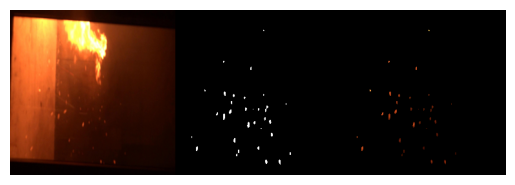

38/38 [==============================] - 82s 2s/step - loss: 0.0076 - mean_iou: 0.5370 - val_loss: 0.0056 - val_mean_iou: 0.5938
Epoch 41/100
103.png
158.png
13.png
131.png
6.png
 1/38 [..............................] - ETA: 1:08 - loss: 0.0081 - mean_iou: 0.587458.png
2.png
123.png
197.png
75.png
 2/38 [>.............................] - ETA: 1:04 - loss: 0.0075 - mean_iou: 0.5860159.png
53.png
93.png
173.png
87.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0076 - mean_iou: 0.6007161.png
41.png
3.png
150.png
107.png
 4/38 [==>...........................] - ETA: 1:14 - loss: 0.0077 - mean_iou: 0.5577116.png
156.png
14.png
172.png
134.png
 5/38 [==>...........................] - ETA: 1:14 - loss: 0.0077 - mean_iou: 0.5516148.png
29.png
121.png
116.png
22.png
 6/38 [===>..........................] - ETA: 1:09 - loss: 0.0088 - mean_iou: 0.522467.png
167.png
48.png
184.png
193.png
 7/38 [====>.........................] - ETA: 1:05 - loss: 0.0090 - mean_iou: 0.525731.png
5

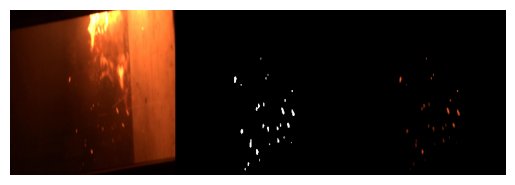

38/38 [==============================] - 84s 2s/step - loss: 0.0077 - mean_iou: 0.5422 - val_loss: 0.0062 - val_mean_iou: 0.6150
Epoch 42/100
86.png
24.png
174.png
130.png
193.png
 1/38 [..............................] - ETA: 1:09 - loss: 0.0068 - mean_iou: 0.6282163.png
179.png
159.png
159.png
83.png
 2/38 [>.............................] - ETA: 1:04 - loss: 0.0066 - mean_iou: 0.593881.png
13.png
110.png
157.png
35.png
 3/38 [=>............................] - ETA: 1:02 - loss: 0.0079 - mean_iou: 0.5732115.png
126.png
65.png
105.png
195.png
 4/38 [==>...........................] - ETA: 1:00 - loss: 0.0083 - mean_iou: 0.5649154.png
127.png
60.png
89.png
130.png
 5/38 [==>...........................] - ETA: 59s - loss: 0.0079 - mean_iou: 0.5455 86.png
44.png
37.png
88.png
21.png
 6/38 [===>..........................] - ETA: 1:05 - loss: 0.0075 - mean_iou: 0.5553139.png
169.png
187.png
170.png
102.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0081 - mean_iou: 0.5556118.

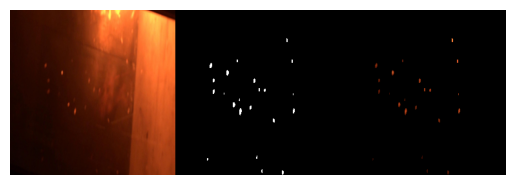

38/38 [==============================] - 80s 2s/step - loss: 0.0077 - mean_iou: 0.5482 - val_loss: 0.0069 - val_mean_iou: 0.5801
Epoch 43/100
33.png
95.png
83.png
73.png
89.png
 1/38 [..............................] - ETA: 1:08 - loss: 0.0049 - mean_iou: 0.577533.png
69.png
56.png
136.png
45.png
 2/38 [>.............................] - ETA: 1:40 - loss: 0.0063 - mean_iou: 0.538739.png
11.png
68.png
6.png
18.png
 3/38 [=>............................] - ETA: 1:32 - loss: 0.0061 - mean_iou: 0.562361.png
64.png
131.png
145.png
192.png
 4/38 [==>...........................] - ETA: 1:20 - loss: 0.0064 - mean_iou: 0.561090.png
134.png
15.png
13.png
151.png
 5/38 [==>...........................] - ETA: 1:13 - loss: 0.0067 - mean_iou: 0.551869.png
144.png
135.png
14.png
111.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0062 - mean_iou: 0.55833.png
142.png
193.png
108.png
122.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0063 - mean_iou: 0.561551.png
72.png


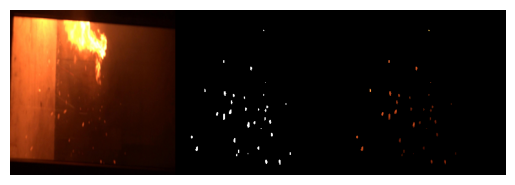

38/38 [==============================] - 84s 2s/step - loss: 0.0075 - mean_iou: 0.5496 - val_loss: 0.0073 - val_mean_iou: 0.6169
Epoch 44/100
110.png
71.png
158.png
198.png
108.png
 1/38 [..............................] - ETA: 1:10 - loss: 0.0068 - mean_iou: 0.4893105.png
126.png
91.png
199.png
57.png
 2/38 [>.............................] - ETA: 1:06 - loss: 0.0070 - mean_iou: 0.4925120.png
60.png
108.png
115.png
56.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0074 - mean_iou: 0.5271187.png
75.png
16.png
94.png
104.png
 4/38 [==>...........................] - ETA: 1:09 - loss: 0.0083 - mean_iou: 0.522938.png
135.png
26.png
24.png
46.png
 5/38 [==>...........................] - ETA: 1:16 - loss: 0.0086 - mean_iou: 0.539712.png
145.png
12.png
147.png
147.png
 6/38 [===>..........................] - ETA: 1:18 - loss: 0.0095 - mean_iou: 0.5169106.png
20.png
156.png
153.png
158.png
 7/38 [====>.........................] - ETA: 1:13 - loss: 0.0096 - mean_iou: 0.5217162.p

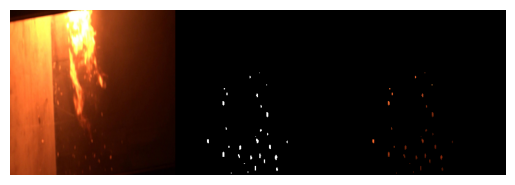

38/38 [==============================] - 83s 2s/step - loss: 0.0075 - mean_iou: 0.5548 - val_loss: 0.0069 - val_mean_iou: 0.5991
Epoch 45/100
61.png
146.png
153.png
143.png
94.png
 1/38 [..............................] - ETA: 1:44 - loss: 0.0079 - mean_iou: 0.614630.png
115.png
142.png
140.png
29.png
 2/38 [>.............................] - ETA: 1:05 - loss: 0.0068 - mean_iou: 0.5584179.png
43.png
198.png
144.png
87.png
 3/38 [=>............................] - ETA: 1:03 - loss: 0.0071 - mean_iou: 0.5695121.png
137.png
188.png
10.png
52.png
 4/38 [==>...........................] - ETA: 1:02 - loss: 0.0064 - mean_iou: 0.577915.png
126.png
132.png
183.png
93.png
 5/38 [==>...........................] - ETA: 1:00 - loss: 0.0066 - mean_iou: 0.587347.png
101.png
161.png
121.png
118.png
 6/38 [===>..........................] - ETA: 57s - loss: 0.0067 - mean_iou: 0.5816 34.png
174.png
63.png
24.png
5.png
 7/38 [====>.........................] - ETA: 58s - loss: 0.0069 - mean_iou: 0.567249.png


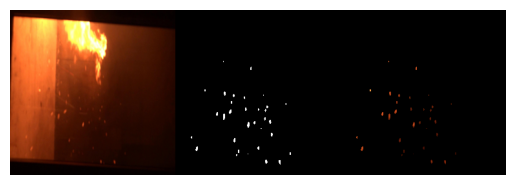

38/38 [==============================] - 81s 2s/step - loss: 0.0070 - mean_iou: 0.5716 - val_loss: 0.0073 - val_mean_iou: 0.6031
Epoch 46/100
97.png
150.png
103.png
147.png
135.png
 1/38 [..............................] - ETA: 1:11 - loss: 0.0030 - mean_iou: 0.5754181.png
138.png
4.png
140.png
122.png
 2/38 [>.............................] - ETA: 1:05 - loss: 0.0061 - mean_iou: 0.544660.png
56.png
147.png
186.png
50.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0069 - mean_iou: 0.5589119.png
24.png
161.png
108.png
33.png
 4/38 [==>...........................] - ETA: 1:16 - loss: 0.0075 - mean_iou: 0.5329181.png
14.png
127.png
124.png
157.png
 5/38 [==>...........................] - ETA: 1:14 - loss: 0.0077 - mean_iou: 0.536633.png
157.png
183.png
158.png
153.png
 6/38 [===>..........................] - ETA: 1:09 - loss: 0.0076 - mean_iou: 0.537518.png
61.png
61.png
108.png
80.png
 7/38 [====>.........................] - ETA: 1:05 - loss: 0.0076 - mean_iou: 0.544744.p

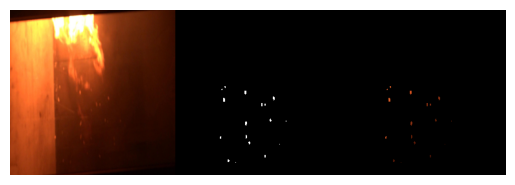

38/38 [==============================] - 85s 2s/step - loss: 0.0069 - mean_iou: 0.5599 - val_loss: 0.0078 - val_mean_iou: 0.5643
Epoch 47/100
116.png
58.png
131.png
40.png
190.png
 1/38 [..............................] - ETA: 1:10 - loss: 0.0085 - mean_iou: 0.497629.png
2.png
41.png
150.png
148.png
 2/38 [>.............................] - ETA: 1:05 - loss: 0.0084 - mean_iou: 0.5455121.png
144.png
36.png
130.png
74.png
 3/38 [=>............................] - ETA: 1:03 - loss: 0.0070 - mean_iou: 0.57374.png
72.png
131.png
85.png
72.png
 4/38 [==>...........................] - ETA: 1:01 - loss: 0.0074 - mean_iou: 0.570752.png
173.png
89.png
124.png
25.png
 5/38 [==>...........................] - ETA: 1:08 - loss: 0.0067 - mean_iou: 0.588643.png
42.png
174.png
81.png
144.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0068 - mean_iou: 0.592415.png
81.png
108.png
112.png
45.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0069 - mean_iou: 0.5913173.png
196.

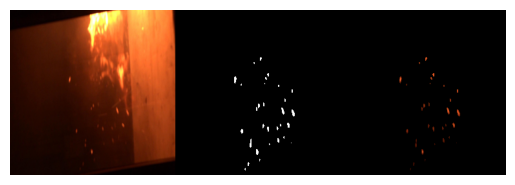

38/38 [==============================] - 80s 2s/step - loss: 0.0075 - mean_iou: 0.5605 - val_loss: 0.0079 - val_mean_iou: 0.5814
Epoch 48/100
79.png
68.png
45.png
49.png
123.png
 1/38 [..............................] - ETA: 1:46 - loss: 0.0075 - mean_iou: 0.5363111.png
121.png
93.png
52.png
82.png
 2/38 [>.............................] - ETA: 1:33 - loss: 0.0082 - mean_iou: 0.543374.png
183.png
29.png
33.png
102.png
 3/38 [=>............................] - ETA: 1:17 - loss: 0.0081 - mean_iou: 0.544630.png
77.png
74.png
116.png
34.png
 4/38 [==>...........................] - ETA: 1:11 - loss: 0.0083 - mean_iou: 0.5388191.png
84.png
11.png
172.png
75.png
 5/38 [==>...........................] - ETA: 1:06 - loss: 0.0082 - mean_iou: 0.5567116.png
143.png
184.png
57.png
3.png
 6/38 [===>..........................] - ETA: 1:03 - loss: 0.0085 - mean_iou: 0.552351.png
150.png
175.png
100.png
30.png
 7/38 [====>.........................] - ETA: 1:00 - loss: 0.0085 - mean_iou: 0.5589174.png
49.p

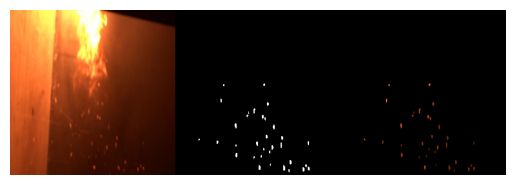

38/38 [==============================] - 86s 2s/step - loss: 0.0076 - mean_iou: 0.5676 - val_loss: 0.0051 - val_mean_iou: 0.5976
Epoch 49/100
140.png
186.png
102.png
91.png
5.png
 1/38 [..............................] - ETA: 1:10 - loss: 0.0066 - mean_iou: 0.443617.png
40.png
57.png
88.png
10.png
 2/38 [>.............................] - ETA: 1:22 - loss: 0.0075 - mean_iou: 0.4915119.png
22.png
168.png
137.png
97.png
 3/38 [=>............................] - ETA: 1:32 - loss: 0.0075 - mean_iou: 0.525450.png
197.png
173.png
20.png
9.png
 4/38 [==>...........................] - ETA: 1:22 - loss: 0.0078 - mean_iou: 0.5435146.png
160.png
161.png
114.png
34.png
 5/38 [==>...........................] - ETA: 1:15 - loss: 0.0069 - mean_iou: 0.5583116.png
21.png
117.png
127.png
74.png
 6/38 [===>..........................] - ETA: 1:10 - loss: 0.0072 - mean_iou: 0.5610183.png
48.png
41.png
134.png
85.png
 7/38 [====>.........................] - ETA: 1:05 - loss: 0.0073 - mean_iou: 0.5523102.png
12

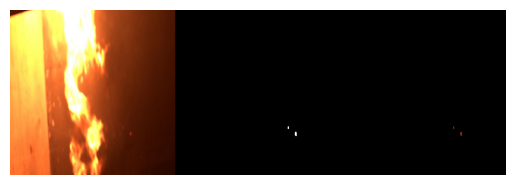

38/38 [==============================] - 84s 2s/step - loss: 0.0069 - mean_iou: 0.5731 - val_loss: 0.0062 - val_mean_iou: 0.5950
Epoch 50/100
91.png
80.png
70.png
160.png
73.png
 1/38 [..............................] - ETA: 1:10 - loss: 0.0079 - mean_iou: 0.5630190.png
11.png
142.png
169.png
137.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0073 - mean_iou: 0.5667159.png
68.png
42.png
141.png
29.png
 3/38 [=>............................] - ETA: 1:05 - loss: 0.0069 - mean_iou: 0.556972.png
148.png
186.png
161.png
179.png
 4/38 [==>...........................] - ETA: 1:04 - loss: 0.0072 - mean_iou: 0.56166.png
47.png
1.png
85.png
117.png
 5/38 [==>...........................] - ETA: 1:11 - loss: 0.0070 - mean_iou: 0.562083.png
181.png
168.png
15.png
110.png
 6/38 [===>..........................] - ETA: 1:10 - loss: 0.0068 - mean_iou: 0.56523.png
43.png
66.png
162.png
183.png
 7/38 [====>.........................] - ETA: 1:06 - loss: 0.0068 - mean_iou: 0.5710156.png
53.

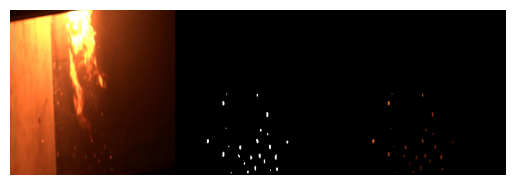

38/38 [==============================] - 81s 2s/step - loss: 0.0073 - mean_iou: 0.5671 - val_loss: 0.0058 - val_mean_iou: 0.6276
Epoch 51/100
96.png
127.png
25.png
160.png
140.png
 1/38 [..............................] - ETA: 1:54 - loss: 0.0110 - mean_iou: 0.5286179.png
32.png
118.png
126.png
200.png
 2/38 [>.............................] - ETA: 1:21 - loss: 0.0117 - mean_iou: 0.5447195.png
17.png
66.png
150.png
173.png
 3/38 [=>............................] - ETA: 1:12 - loss: 0.0119 - mean_iou: 0.4788195.png
154.png
142.png
135.png
196.png
 4/38 [==>...........................] - ETA: 1:07 - loss: 0.0106 - mean_iou: 0.523474.png
27.png
167.png
21.png
11.png
 5/38 [==>...........................] - ETA: 1:04 - loss: 0.0099 - mean_iou: 0.5465170.png
165.png
17.png
61.png
137.png
 6/38 [===>..........................] - ETA: 1:01 - loss: 0.0097 - mean_iou: 0.535288.png
143.png
125.png
141.png
193.png
 7/38 [====>.........................] - ETA: 59s - loss: 0.0094 - mean_iou: 0.5379 19

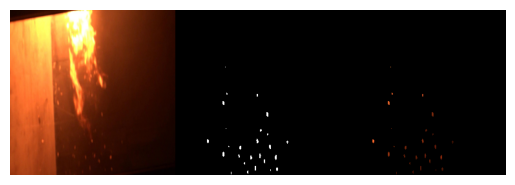

38/38 [==============================] - 85s 2s/step - loss: 0.0070 - mean_iou: 0.5758 - val_loss: 0.0036 - val_mean_iou: 0.6377
Epoch 52/100
88.png
128.png
142.png
61.png
93.png
 1/38 [..............................] - ETA: 1:10 - loss: 0.0059 - mean_iou: 0.5563116.png
50.png
60.png
49.png
46.png
 2/38 [>.............................] - ETA: 1:06 - loss: 0.0059 - mean_iou: 0.569665.png
130.png
126.png
122.png
23.png
 3/38 [=>............................] - ETA: 1:15 - loss: 0.0070 - mean_iou: 0.571511.png
39.png
190.png
102.png
174.png
 4/38 [==>...........................] - ETA: 1:20 - loss: 0.0068 - mean_iou: 0.593047.png
31.png
161.png
103.png
27.png
 5/38 [==>...........................] - ETA: 1:13 - loss: 0.0076 - mean_iou: 0.5662188.png
91.png
106.png
189.png
27.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0079 - mean_iou: 0.5775158.png
6.png
106.png
13.png
124.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0079 - mean_iou: 0.56724.png
135

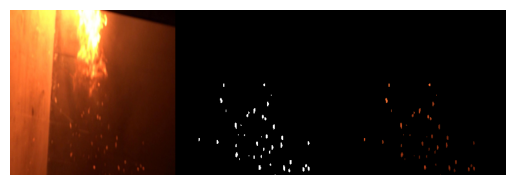

38/38 [==============================] - 84s 2s/step - loss: 0.0066 - mean_iou: 0.5818 - val_loss: 0.0075 - val_mean_iou: 0.5971
Epoch 53/100
124.png
147.png
49.png
88.png
177.png
 1/38 [..............................] - ETA: 1:13 - loss: 0.0053 - mean_iou: 0.6107163.png
116.png
71.png
85.png
143.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0056 - mean_iou: 0.61321.png
108.png
141.png
141.png
58.png
 3/38 [=>............................] - ETA: 1:05 - loss: 0.0052 - mean_iou: 0.6064163.png
116.png
166.png
50.png
119.png
 4/38 [==>...........................] - ETA: 1:02 - loss: 0.0054 - mean_iou: 0.601082.png
50.png
10.png
44.png
48.png
 5/38 [==>...........................] - ETA: 1:05 - loss: 0.0061 - mean_iou: 0.595381.png
100.png
106.png
174.png
183.png
 6/38 [===>..........................] - ETA: 1:09 - loss: 0.0063 - mean_iou: 0.583318.png
130.png
41.png
27.png
8.png
 7/38 [====>.........................] - ETA: 1:08 - loss: 0.0068 - mean_iou: 0.580516.png
54

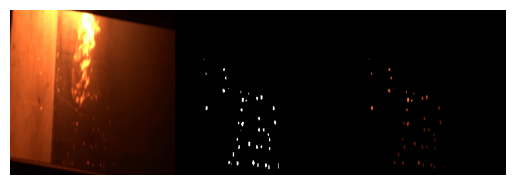

38/38 [==============================] - 84s 2s/step - loss: 0.0068 - mean_iou: 0.5827 - val_loss: 0.0063 - val_mean_iou: 0.6290
Epoch 54/100
117.png
192.png
169.png
180.png
158.png
 1/38 [..............................] - ETA: 1:16 - loss: 0.0060 - mean_iou: 0.6076124.png
33.png
82.png
184.png
103.png
 2/38 [>.............................] - ETA: 1:44 - loss: 0.0051 - mean_iou: 0.600923.png
9.png
30.png
133.png
13.png
 3/38 [=>............................] - ETA: 1:31 - loss: 0.0060 - mean_iou: 0.607655.png
39.png
89.png
8.png
139.png
 4/38 [==>...........................] - ETA: 1:20 - loss: 0.0068 - mean_iou: 0.588421.png
104.png
78.png
124.png
51.png
 5/38 [==>...........................] - ETA: 1:13 - loss: 0.0073 - mean_iou: 0.5907172.png
170.png
13.png
132.png
116.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0072 - mean_iou: 0.566527.png
1.png
145.png
105.png
38.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0069 - mean_iou: 0.5812108.png
12

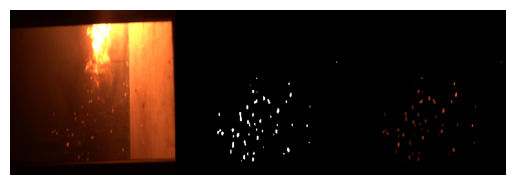

38/38 [==============================] - 83s 2s/step - loss: 0.0070 - mean_iou: 0.5894 - val_loss: 0.0079 - val_mean_iou: 0.6120
Epoch 55/100
144.png
192.png
56.png
162.png
33.png
 1/38 [..............................] - ETA: 1:09 - loss: 0.0089 - mean_iou: 0.555496.png
44.png
87.png
193.png
117.png
 2/38 [>.............................] - ETA: 1:04 - loss: 0.0080 - mean_iou: 0.5813117.png
129.png
96.png
50.png
104.png
 3/38 [=>............................] - ETA: 1:03 - loss: 0.0086 - mean_iou: 0.558985.png
150.png
1.png
3.png
67.png
 4/38 [==>...........................] - ETA: 1:03 - loss: 0.0077 - mean_iou: 0.57322.png
19.png
103.png
45.png
43.png
 5/38 [==>...........................] - ETA: 1:10 - loss: 0.0078 - mean_iou: 0.571611.png
16.png
171.png
66.png
25.png
 6/38 [===>..........................] - ETA: 1:09 - loss: 0.0079 - mean_iou: 0.5825105.png
180.png
176.png
58.png
90.png
 7/38 [====>.........................] - ETA: 1:05 - loss: 0.0074 - mean_iou: 0.572080.png
158.png

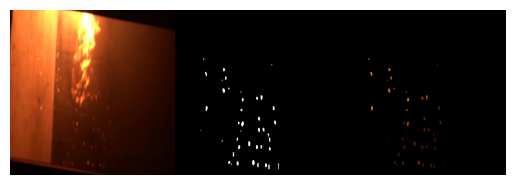

38/38 [==============================] - 82s 2s/step - loss: 0.0066 - mean_iou: 0.5747 - val_loss: 0.0064 - val_mean_iou: 0.6276
Epoch 56/100
187.png
195.png
32.png
51.png
181.png
 1/38 [..............................] - ETA: 1:53 - loss: 0.0060 - mean_iou: 0.635920.png
83.png
191.png
191.png
161.png
 2/38 [>.............................] - ETA: 1:54 - loss: 0.0060 - mean_iou: 0.5823135.png
191.png
87.png
107.png
66.png
 3/38 [=>............................] - ETA: 1:42 - loss: 0.0056 - mean_iou: 0.589629.png
24.png
38.png
140.png
49.png
 4/38 [==>...........................] - ETA: 1:27 - loss: 0.0060 - mean_iou: 0.5938150.png
16.png
109.png
157.png
170.png
 5/38 [==>...........................] - ETA: 1:19 - loss: 0.0058 - mean_iou: 0.589357.png
181.png
13.png
42.png
45.png
 6/38 [===>..........................] - ETA: 1:13 - loss: 0.0062 - mean_iou: 0.5843110.png
17.png
30.png
149.png
158.png
 7/38 [====>.........................] - ETA: 1:12 - loss: 0.0060 - mean_iou: 0.596976.png


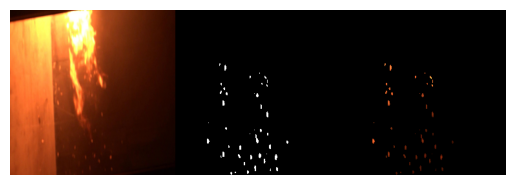

38/38 [==============================] - 85s 2s/step - loss: 0.0067 - mean_iou: 0.5831 - val_loss: 0.0114 - val_mean_iou: 0.5621
Epoch 57/100
73.png
170.png
163.png
161.png
41.png
 1/38 [..............................] - ETA: 1:10 - loss: 0.0099 - mean_iou: 0.5524151.png
34.png
14.png
64.png
64.png
 2/38 [>.............................] - ETA: 1:05 - loss: 0.0086 - mean_iou: 0.5352170.png
138.png
85.png
40.png
82.png
 3/38 [=>............................] - ETA: 1:21 - loss: 0.0080 - mean_iou: 0.5583118.png
125.png
72.png
143.png
108.png
 4/38 [==>...........................] - ETA: 1:21 - loss: 0.0074 - mean_iou: 0.551270.png
129.png
141.png
163.png
148.png
 5/38 [==>...........................] - ETA: 1:14 - loss: 0.0068 - mean_iou: 0.567660.png
191.png
80.png
181.png
8.png
 6/38 [===>..........................] - ETA: 1:10 - loss: 0.0068 - mean_iou: 0.564083.png
21.png
169.png
102.png
59.png
 7/38 [====>.........................] - ETA: 1:06 - loss: 0.0070 - mean_iou: 0.5761133.png


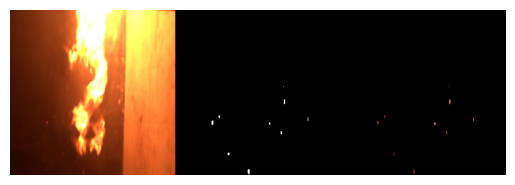

38/38 [==============================] - 85s 2s/step - loss: 0.0071 - mean_iou: 0.5837 - val_loss: 0.0067 - val_mean_iou: 0.6211
Epoch 58/100
142.png
111.png
22.png
97.png
127.png
 1/38 [..............................] - ETA: 1:13 - loss: 0.0050 - mean_iou: 0.6423134.png
20.png
17.png
171.png
3.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0049 - mean_iou: 0.613959.png
124.png
82.png
190.png
97.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0051 - mean_iou: 0.613079.png
33.png
139.png
145.png
77.png
 4/38 [==>...........................] - ETA: 1:07 - loss: 0.0053 - mean_iou: 0.635467.png
142.png
171.png
7.png
188.png
 5/38 [==>...........................] - ETA: 1:13 - loss: 0.0053 - mean_iou: 0.61277.png
170.png
9.png
5.png
111.png
 6/38 [===>..........................] - ETA: 1:09 - loss: 0.0055 - mean_iou: 0.6154102.png
137.png
130.png
15.png
65.png
 7/38 [====>.........................] - ETA: 1:05 - loss: 0.0058 - mean_iou: 0.605924.png
196.pn

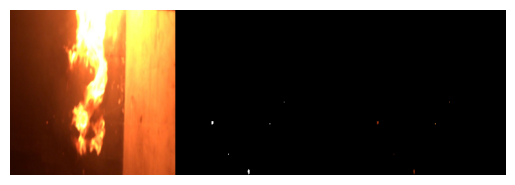

38/38 [==============================] - 87s 2s/step - loss: 0.0071 - mean_iou: 0.5879 - val_loss: 0.0061 - val_mean_iou: 0.5888
Epoch 59/100
35.png
186.png
64.png
167.png
189.png
 1/38 [..............................] - ETA: 1:11 - loss: 0.0067 - mean_iou: 0.5655141.png
90.png
133.png
32.png
121.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0067 - mean_iou: 0.57923.png
157.png
121.png
9.png
10.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0073 - mean_iou: 0.583340.png
49.png
156.png
87.png
8.png
 4/38 [==>...........................] - ETA: 1:03 - loss: 0.0076 - mean_iou: 0.580744.png
108.png
11.png
180.png
117.png
 5/38 [==>...........................] - ETA: 1:06 - loss: 0.0080 - mean_iou: 0.562477.png
151.png
167.png
138.png
81.png
 6/38 [===>..........................] - ETA: 1:10 - loss: 0.0073 - mean_iou: 0.571068.png
52.png
82.png
162.png
41.png
 7/38 [====>.........................] - ETA: 1:05 - loss: 0.0068 - mean_iou: 0.5722110.png
145.

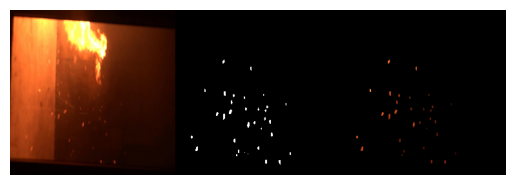

38/38 [==============================] - 82s 2s/step - loss: 0.0066 - mean_iou: 0.5911 - val_loss: 0.0061 - val_mean_iou: 0.6511
Epoch 60/100
36.png
136.png
87.png
142.png
26.png
 1/38 [..............................] - ETA: 1:43 - loss: 0.0070 - mean_iou: 0.6182196.png
84.png
183.png
47.png
48.png
 2/38 [>.............................] - ETA: 1:36 - loss: 0.0071 - mean_iou: 0.624420.png
147.png
164.png
75.png
97.png
 3/38 [=>............................] - ETA: 1:19 - loss: 0.0072 - mean_iou: 0.6056118.png
112.png
79.png
146.png
74.png
 4/38 [==>...........................] - ETA: 1:11 - loss: 0.0071 - mean_iou: 0.6103130.png
21.png
117.png
177.png
29.png
 5/38 [==>...........................] - ETA: 1:07 - loss: 0.0069 - mean_iou: 0.605848.png
95.png
96.png
181.png
120.png
 6/38 [===>..........................] - ETA: 1:03 - loss: 0.0066 - mean_iou: 0.5981192.png
50.png
58.png
120.png
45.png
 7/38 [====>.........................] - ETA: 1:00 - loss: 0.0068 - mean_iou: 0.603598.png
16

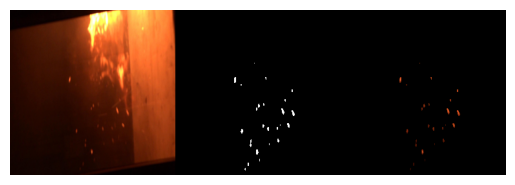

38/38 [==============================] - 85s 2s/step - loss: 0.0064 - mean_iou: 0.6014 - val_loss: 0.0071 - val_mean_iou: 0.5850
Epoch 61/100
1.png
61.png
33.png
101.png
104.png
 1/38 [..............................] - ETA: 1:11 - loss: 0.0078 - mean_iou: 0.542475.png
101.png
47.png
88.png
104.png
 2/38 [>.............................] - ETA: 1:06 - loss: 0.0066 - mean_iou: 0.5915199.png
53.png
73.png
16.png
196.png
 3/38 [=>............................] - ETA: 1:16 - loss: 0.0059 - mean_iou: 0.598867.png
150.png
100.png
132.png
27.png
 4/38 [==>...........................] - ETA: 1:22 - loss: 0.0058 - mean_iou: 0.614970.png
128.png
22.png
19.png
107.png
 5/38 [==>...........................] - ETA: 1:14 - loss: 0.0057 - mean_iou: 0.630941.png
35.png
82.png
65.png
43.png
 6/38 [===>..........................] - ETA: 1:09 - loss: 0.0065 - mean_iou: 0.6068146.png
23.png
33.png
158.png
141.png
 7/38 [====>.........................] - ETA: 1:05 - loss: 0.0069 - mean_iou: 0.61125.png
132.pn

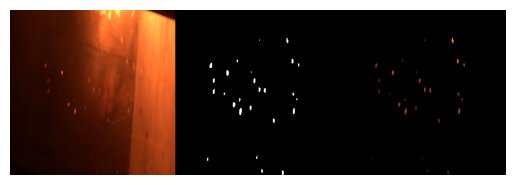

38/38 [==============================] - 84s 2s/step - loss: 0.0061 - mean_iou: 0.6044 - val_loss: 0.0077 - val_mean_iou: 0.6163
Epoch 62/100
150.png
94.png
54.png
181.png
121.png
 1/38 [..............................] - ETA: 1:12 - loss: 0.0067 - mean_iou: 0.636835.png
81.png
79.png
192.png
199.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0063 - mean_iou: 0.638858.png
48.png
13.png
96.png
195.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0065 - mean_iou: 0.613224.png
153.png
59.png
184.png
101.png
 4/38 [==>...........................] - ETA: 1:02 - loss: 0.0062 - mean_iou: 0.6208153.png
2.png
103.png
14.png
116.png
 5/38 [==>...........................] - ETA: 1:03 - loss: 0.0069 - mean_iou: 0.602320.png
132.png
111.png
11.png
133.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0065 - mean_iou: 0.6120175.png
179.png
163.png
173.png
129.png
 7/38 [====>.........................] - ETA: 1:06 - loss: 0.0064 - mean_iou: 0.613164.png

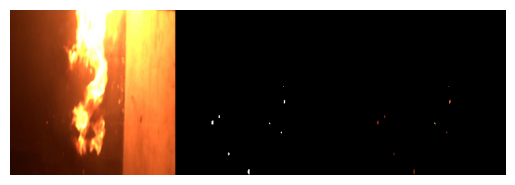

38/38 [==============================] - 85s 2s/step - loss: 0.0066 - mean_iou: 0.5995 - val_loss: 0.0068 - val_mean_iou: 0.6618
Epoch 63/100
36.png
181.png
109.png
70.png
57.png
 1/38 [..............................] - ETA: 1:36 - loss: 0.0080 - mean_iou: 0.585715.png
192.png
96.png
38.png
1.png
 2/38 [>.............................] - ETA: 1:08 - loss: 0.0062 - mean_iou: 0.62418.png
6.png
85.png
7.png
195.png
 3/38 [=>............................] - ETA: 1:05 - loss: 0.0069 - mean_iou: 0.6059101.png
42.png
77.png
167.png
173.png
 4/38 [==>...........................] - ETA: 1:03 - loss: 0.0069 - mean_iou: 0.6039170.png
196.png
125.png
110.png
197.png
 5/38 [==>...........................] - ETA: 1:01 - loss: 0.0063 - mean_iou: 0.608946.png
42.png
86.png
108.png
112.png
 6/38 [===>..........................] - ETA: 1:00 - loss: 0.0061 - mean_iou: 0.5981159.png
85.png
119.png
49.png
1.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0062 - mean_iou: 0.592659.png
130.png

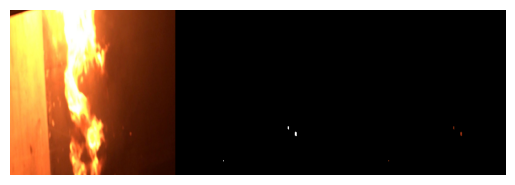

38/38 [==============================] - 83s 2s/step - loss: 0.0064 - mean_iou: 0.6031 - val_loss: 0.0061 - val_mean_iou: 0.6661
Epoch 64/100
83.png
89.png
9.png
19.png
116.png
 1/38 [..............................] - ETA: 1:11 - loss: 0.0069 - mean_iou: 0.599272.png
141.png
41.png
9.png
151.png
 2/38 [>.............................] - ETA: 1:08 - loss: 0.0060 - mean_iou: 0.632624.png
53.png
156.png
33.png
14.png
 3/38 [=>............................] - ETA: 1:24 - loss: 0.0064 - mean_iou: 0.6359158.png
44.png
197.png
96.png
196.png
 4/38 [==>...........................] - ETA: 1:22 - loss: 0.0063 - mean_iou: 0.633523.png
22.png
74.png
86.png
24.png
 5/38 [==>...........................] - ETA: 1:14 - loss: 0.0061 - mean_iou: 0.628912.png
84.png
145.png
198.png
38.png
 6/38 [===>..........................] - ETA: 1:10 - loss: 0.0059 - mean_iou: 0.6222181.png
115.png
34.png
157.png
192.png
 7/38 [====>.........................] - ETA: 1:06 - loss: 0.0060 - mean_iou: 0.6189148.png
3.png


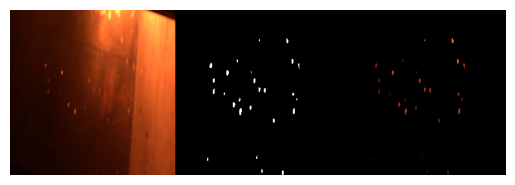

38/38 [==============================] - 85s 2s/step - loss: 0.0065 - mean_iou: 0.5971 - val_loss: 0.0040 - val_mean_iou: 0.6224
Epoch 65/100
189.png
6.png
111.png
3.png
192.png
 1/38 [..............................] - ETA: 1:10 - loss: 0.0058 - mean_iou: 0.605659.png
187.png
183.png
55.png
60.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0069 - mean_iou: 0.5939159.png
130.png
60.png
93.png
184.png
 3/38 [=>............................] - ETA: 1:06 - loss: 0.0062 - mean_iou: 0.5856118.png
189.png
8.png
168.png
48.png
 4/38 [==>...........................] - ETA: 1:03 - loss: 0.0061 - mean_iou: 0.592618.png
170.png
45.png
102.png
87.png
 5/38 [==>...........................] - ETA: 1:07 - loss: 0.0061 - mean_iou: 0.5953151.png
196.png
72.png
3.png
173.png
 6/38 [===>..........................] - ETA: 1:10 - loss: 0.0061 - mean_iou: 0.598220.png
3.png
19.png
14.png
89.png
 7/38 [====>.........................] - ETA: 1:06 - loss: 0.0062 - mean_iou: 0.600827.png
131.png

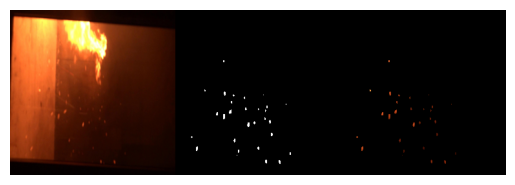

38/38 [==============================] - 84s 2s/step - loss: 0.0063 - mean_iou: 0.5971 - val_loss: 0.0050 - val_mean_iou: 0.6031
Epoch 66/100
141.png
172.png
123.png
147.png
195.png
 1/38 [..............................] - ETA: 1:24 - loss: 0.0069 - mean_iou: 0.4876136.png
18.png
37.png
43.png
26.png
 2/38 [>.............................] - ETA: 1:52 - loss: 0.0071 - mean_iou: 0.562791.png
70.png
75.png
135.png
33.png
 3/38 [=>............................] - ETA: 1:32 - loss: 0.0077 - mean_iou: 0.53143.png
63.png
200.png
116.png
92.png
 4/38 [==>...........................] - ETA: 1:20 - loss: 0.0082 - mean_iou: 0.5486166.png
57.png
26.png
187.png
98.png
 5/38 [==>...........................] - ETA: 1:14 - loss: 0.0076 - mean_iou: 0.5599190.png
45.png
90.png
190.png
42.png
 6/38 [===>..........................] - ETA: 1:09 - loss: 0.0071 - mean_iou: 0.5773126.png
33.png
137.png
44.png
33.png
 7/38 [====>.........................] - ETA: 1:06 - loss: 0.0071 - mean_iou: 0.5862187.png
135

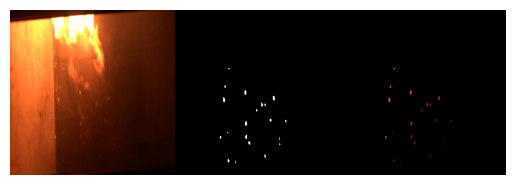

38/38 [==============================] - 85s 2s/step - loss: 0.0063 - mean_iou: 0.6090 - val_loss: 0.0056 - val_mean_iou: 0.6456
Epoch 67/100
98.png
39.png
6.png
75.png
102.png
 1/38 [..............................] - ETA: 1:09 - loss: 0.0064 - mean_iou: 0.645631.png
39.png
107.png
195.png
120.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0053 - mean_iou: 0.584838.png
181.png
19.png
86.png
180.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0052 - mean_iou: 0.594795.png
110.png
197.png
140.png
50.png
 4/38 [==>...........................] - ETA: 1:09 - loss: 0.0052 - mean_iou: 0.609369.png
158.png
78.png
83.png
133.png
 5/38 [==>...........................] - ETA: 1:14 - loss: 0.0058 - mean_iou: 0.612834.png
188.png
121.png
114.png
186.png
 6/38 [===>..........................] - ETA: 1:10 - loss: 0.0057 - mean_iou: 0.6105106.png
2.png
129.png
193.png
51.png
 7/38 [====>.........................] - ETA: 1:07 - loss: 0.0061 - mean_iou: 0.599033.png
83

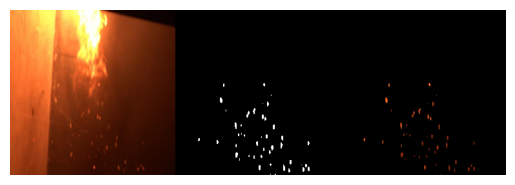

38/38 [==============================] - 87s 2s/step - loss: 0.0063 - mean_iou: 0.6060 - val_loss: 0.0055 - val_mean_iou: 0.6409
Epoch 68/100
119.png
10.png
157.png
37.png
98.png
 1/38 [..............................] - ETA: 1:12 - loss: 0.0076 - mean_iou: 0.602845.png
98.png
156.png
197.png
56.png
 2/38 [>.............................] - ETA: 1:06 - loss: 0.0073 - mean_iou: 0.6047150.png
191.png
200.png
176.png
60.png
 3/38 [=>............................] - ETA: 1:05 - loss: 0.0068 - mean_iou: 0.6326180.png
112.png
191.png
84.png
44.png
 4/38 [==>...........................] - ETA: 1:03 - loss: 0.0064 - mean_iou: 0.6408175.png
48.png
53.png
196.png
12.png
 5/38 [==>...........................] - ETA: 1:05 - loss: 0.0060 - mean_iou: 0.635087.png
135.png
187.png
102.png
31.png
 6/38 [===>..........................] - ETA: 1:09 - loss: 0.0060 - mean_iou: 0.6236115.png
136.png
166.png
190.png
71.png
 7/38 [====>.........................] - ETA: 1:06 - loss: 0.0061 - mean_iou: 0.6222200.p

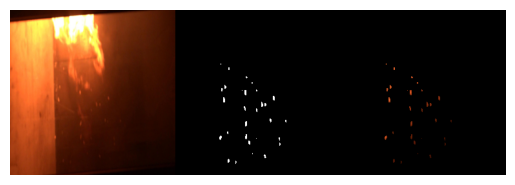

38/38 [==============================] - 82s 2s/step - loss: 0.0067 - mean_iou: 0.5990 - val_loss: 0.0076 - val_mean_iou: 0.6056
Epoch 69/100
30.png
57.png
52.png
32.png
34.png
 1/38 [..............................] - ETA: 1:50 - loss: 0.0057 - mean_iou: 0.595361.png
37.png
183.png
36.png
129.png
 2/38 [>.............................] - ETA: 1:35 - loss: 0.0059 - mean_iou: 0.5853135.png
125.png
198.png
49.png
73.png
 3/38 [=>............................] - ETA: 1:19 - loss: 0.0058 - mean_iou: 0.604017.png
119.png
72.png
39.png
157.png
 4/38 [==>...........................] - ETA: 1:12 - loss: 0.0053 - mean_iou: 0.63059.png
137.png
105.png
39.png
144.png
 5/38 [==>...........................] - ETA: 1:08 - loss: 0.0053 - mean_iou: 0.636523.png
8.png
197.png
38.png
127.png
 6/38 [===>..........................] - ETA: 1:05 - loss: 0.0056 - mean_iou: 0.6313135.png
48.png
10.png
149.png
129.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0056 - mean_iou: 0.6351172.png
40.p

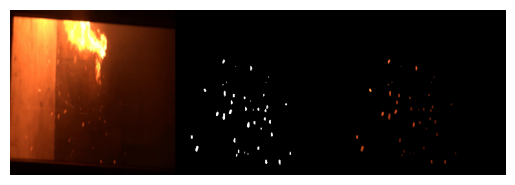

38/38 [==============================] - 86s 2s/step - loss: 0.0058 - mean_iou: 0.6122 - val_loss: 0.0061 - val_mean_iou: 0.6092
Epoch 70/100
142.png
90.png
96.png
102.png
37.png
 1/38 [..............................] - ETA: 1:13 - loss: 0.0049 - mean_iou: 0.5972128.png
169.png
58.png
131.png
146.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0059 - mean_iou: 0.5786103.png
144.png
120.png
153.png
72.png
 3/38 [=>............................] - ETA: 1:18 - loss: 0.0065 - mean_iou: 0.609220.png
5.png
39.png
183.png
5.png
 4/38 [==>...........................] - ETA: 1:23 - loss: 0.0063 - mean_iou: 0.632818.png
72.png
8.png
43.png
17.png
 5/38 [==>...........................] - ETA: 1:15 - loss: 0.0061 - mean_iou: 0.6232128.png
146.png
112.png
174.png
142.png
 6/38 [===>..........................] - ETA: 1:10 - loss: 0.0061 - mean_iou: 0.628889.png
32.png
11.png
102.png
98.png
 7/38 [====>.........................] - ETA: 1:06 - loss: 0.0059 - mean_iou: 0.6291141.png
165

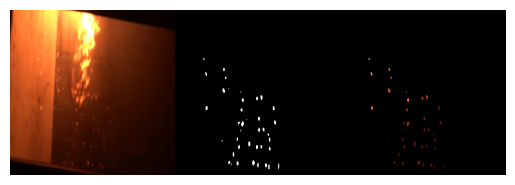

38/38 [==============================] - 84s 2s/step - loss: 0.0064 - mean_iou: 0.6102 - val_loss: 0.0048 - val_mean_iou: 0.6677
Epoch 71/100
41.png
137.png
51.png
121.png
112.png
 1/38 [..............................] - ETA: 1:11 - loss: 0.0025 - mean_iou: 0.6635141.png
72.png
161.png
79.png
61.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0032 - mean_iou: 0.674021.png
57.png
188.png
67.png
146.png
 3/38 [=>............................] - ETA: 1:05 - loss: 0.0040 - mean_iou: 0.666268.png
55.png
35.png
173.png
2.png
 4/38 [==>...........................] - ETA: 1:03 - loss: 0.0044 - mean_iou: 0.675424.png
32.png
35.png
68.png
144.png
 5/38 [==>...........................] - ETA: 1:01 - loss: 0.0048 - mean_iou: 0.6570102.png
102.png
163.png
65.png
60.png
 6/38 [===>..........................] - ETA: 1:07 - loss: 0.0050 - mean_iou: 0.6532124.png
101.png
37.png
142.png
34.png
 7/38 [====>.........................] - ETA: 1:06 - loss: 0.0050 - mean_iou: 0.6404129.png
17.

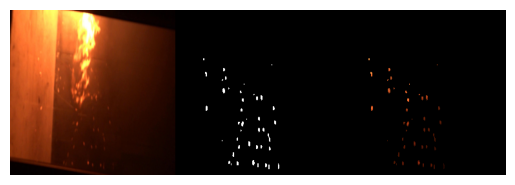

38/38 [==============================] - 83s 2s/step - loss: 0.0057 - mean_iou: 0.6218 - val_loss: 0.0049 - val_mean_iou: 0.6200
Epoch 72/100
102.png
114.png
20.png
4.png
2.png
 1/38 [..............................] - ETA: 1:47 - loss: 0.0061 - mean_iou: 0.6314129.png
149.png
136.png
164.png
75.png
 2/38 [>.............................] - ETA: 1:50 - loss: 0.0054 - mean_iou: 0.6132122.png
125.png
41.png
23.png
160.png
 3/38 [=>............................] - ETA: 1:45 - loss: 0.0068 - mean_iou: 0.6248111.png
21.png
153.png
166.png
166.png
 4/38 [==>...........................] - ETA: 1:33 - loss: 0.0066 - mean_iou: 0.6301162.png
175.png
122.png
146.png
81.png
 5/38 [==>...........................] - ETA: 1:22 - loss: 0.0064 - mean_iou: 0.6274158.png
151.png
98.png
95.png
120.png
 6/38 [===>..........................] - ETA: 1:16 - loss: 0.0063 - mean_iou: 0.639763.png
9.png
86.png
73.png
55.png
 7/38 [====>.........................] - ETA: 1:14 - loss: 0.0060 - mean_iou: 0.6434147.png


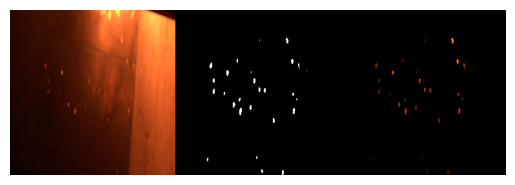

38/38 [==============================] - 87s 2s/step - loss: 0.0060 - mean_iou: 0.6115 - val_loss: 0.0049 - val_mean_iou: 0.6201
Epoch 73/100
174.png
39.png
171.png
8.png
68.png
 1/38 [..............................] - ETA: 1:13 - loss: 0.0072 - mean_iou: 0.642368.png
77.png
53.png
29.png
138.png
 2/38 [>.............................] - ETA: 1:16 - loss: 0.0067 - mean_iou: 0.6350139.png
48.png
128.png
192.png
63.png
 3/38 [=>............................] - ETA: 1:29 - loss: 0.0062 - mean_iou: 0.6350171.png
24.png
58.png
3.png
4.png
 4/38 [==>...........................] - ETA: 1:23 - loss: 0.0067 - mean_iou: 0.6021132.png
110.png
96.png
65.png
19.png
 5/38 [==>...........................] - ETA: 1:16 - loss: 0.0068 - mean_iou: 0.5973174.png
130.png
142.png
92.png
48.png
 6/38 [===>..........................] - ETA: 1:11 - loss: 0.0070 - mean_iou: 0.6010172.png
40.png
112.png
68.png
46.png
 7/38 [====>.........................] - ETA: 1:07 - loss: 0.0067 - mean_iou: 0.5849199.png
40.png

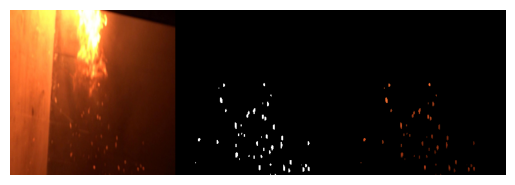

38/38 [==============================] - 86s 2s/step - loss: 0.0068 - mean_iou: 0.5964 - val_loss: 0.0060 - val_mean_iou: 0.6557
Epoch 74/100
125.png
119.png
74.png
12.png
158.png
 1/38 [..............................] - ETA: 1:12 - loss: 0.0060 - mean_iou: 0.6615150.png
172.png
105.png
108.png
102.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0056 - mean_iou: 0.6550101.png
169.png
86.png
50.png
10.png
 3/38 [=>............................] - ETA: 1:05 - loss: 0.0051 - mean_iou: 0.641088.png
64.png
55.png
27.png
108.png
 4/38 [==>...........................] - ETA: 1:06 - loss: 0.0057 - mean_iou: 0.6378115.png
169.png
80.png
98.png
30.png
 5/38 [==>...........................] - ETA: 1:13 - loss: 0.0064 - mean_iou: 0.640397.png
171.png
161.png
55.png
149.png
 6/38 [===>..........................] - ETA: 1:10 - loss: 0.0062 - mean_iou: 0.636222.png
71.png
111.png
176.png
37.png
 7/38 [====>.........................] - ETA: 1:07 - loss: 0.0060 - mean_iou: 0.6402116.png

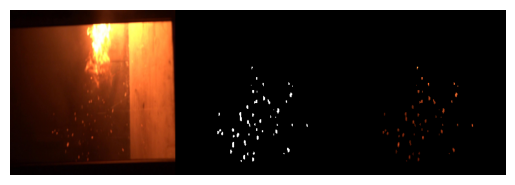

38/38 [==============================] - 85s 2s/step - loss: 0.0067 - mean_iou: 0.6314 - val_loss: 0.0084 - val_mean_iou: 0.5679
Epoch 75/100
71.png
166.png
187.png
140.png
13.png
 1/38 [..............................] - ETA: 1:54 - loss: 0.0085 - mean_iou: 0.591379.png
108.png
56.png
116.png
198.png
 2/38 [>.............................] - ETA: 1:30 - loss: 0.0078 - mean_iou: 0.6113180.png
18.png
52.png
4.png
64.png
 3/38 [=>............................] - ETA: 1:16 - loss: 0.0066 - mean_iou: 0.622090.png
72.png
47.png
136.png
24.png
 4/38 [==>...........................] - ETA: 1:11 - loss: 0.0064 - mean_iou: 0.6197107.png
186.png
40.png
101.png
13.png
 5/38 [==>...........................] - ETA: 1:07 - loss: 0.0070 - mean_iou: 0.614147.png
162.png
146.png
174.png
40.png
 6/38 [===>..........................] - ETA: 1:04 - loss: 0.0065 - mean_iou: 0.615824.png
29.png
115.png
8.png
143.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0064 - mean_iou: 0.6100174.png
186

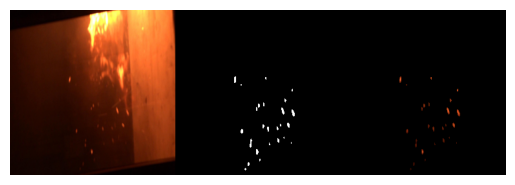

38/38 [==============================] - 89s 2s/step - loss: 0.0064 - mean_iou: 0.6124 - val_loss: 0.0037 - val_mean_iou: 0.6262
Epoch 76/100
158.png
38.png
184.png
145.png
84.png
 1/38 [..............................] - ETA: 1:14 - loss: 0.0042 - mean_iou: 0.6635123.png
149.png
63.png
2.png
33.png
 2/38 [>.............................] - ETA: 1:11 - loss: 0.0045 - mean_iou: 0.6532162.png
37.png
119.png
175.png
30.png
 3/38 [=>............................] - ETA: 1:28 - loss: 0.0046 - mean_iou: 0.6710174.png
36.png
128.png
70.png
136.png
 4/38 [==>...........................] - ETA: 1:24 - loss: 0.0050 - mean_iou: 0.657843.png
126.png
43.png
2.png
189.png
 5/38 [==>...........................] - ETA: 1:16 - loss: 0.0050 - mean_iou: 0.655086.png
166.png
166.png
10.png
59.png
 6/38 [===>..........................] - ETA: 1:11 - loss: 0.0052 - mean_iou: 0.657135.png
57.png
200.png
10.png
131.png
 7/38 [====>.........................] - ETA: 1:07 - loss: 0.0055 - mean_iou: 0.645527.png
159

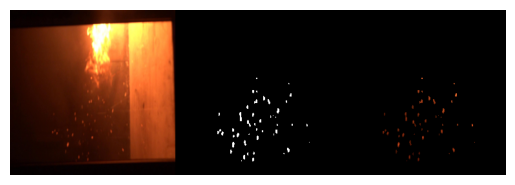

38/38 [==============================] - 87s 2s/step - loss: 0.0059 - mean_iou: 0.6182 - val_loss: 0.0074 - val_mean_iou: 0.6051
Epoch 77/100
36.png
101.png
130.png
41.png
166.png
 1/38 [..............................] - ETA: 1:14 - loss: 0.0083 - mean_iou: 0.635741.png
197.png
93.png
192.png
104.png
 2/38 [>.............................] - ETA: 1:08 - loss: 0.0068 - mean_iou: 0.623986.png
39.png
133.png
60.png
94.png
 3/38 [=>............................] - ETA: 1:06 - loss: 0.0057 - mean_iou: 0.608123.png
140.png
45.png
110.png
92.png
 4/38 [==>...........................] - ETA: 1:05 - loss: 0.0055 - mean_iou: 0.62821.png
197.png
92.png
114.png
196.png
 5/38 [==>...........................] - ETA: 1:12 - loss: 0.0057 - mean_iou: 0.633796.png
58.png
134.png
196.png
17.png
 6/38 [===>..........................] - ETA: 1:11 - loss: 0.0059 - mean_iou: 0.6207109.png
145.png
2.png
68.png
54.png
 7/38 [====>.........................] - ETA: 1:07 - loss: 0.0061 - mean_iou: 0.623856.png
184.

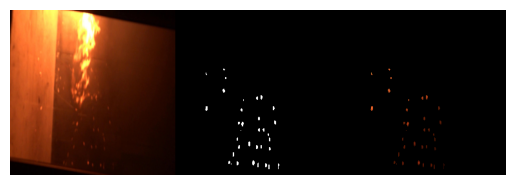

38/38 [==============================] - 84s 2s/step - loss: 0.0061 - mean_iou: 0.6154 - val_loss: 0.0047 - val_mean_iou: 0.6428
Epoch 78/100
170.png
86.png
132.png
157.png
80.png
 1/38 [..............................] - ETA: 1:47 - loss: 0.0036 - mean_iou: 0.637329.png
150.png
15.png
158.png
29.png
 2/38 [>.............................] - ETA: 1:25 - loss: 0.0044 - mean_iou: 0.656376.png
189.png
46.png
136.png
168.png
 3/38 [=>............................] - ETA: 1:15 - loss: 0.0052 - mean_iou: 0.637376.png
153.png
101.png
111.png
115.png
 4/38 [==>...........................] - ETA: 1:11 - loss: 0.0053 - mean_iou: 0.636596.png
88.png
66.png
54.png
154.png
 5/38 [==>...........................] - ETA: 1:07 - loss: 0.0050 - mean_iou: 0.6458140.png
156.png
106.png
43.png
157.png
 6/38 [===>..........................] - ETA: 1:04 - loss: 0.0052 - mean_iou: 0.638493.png
116.png
144.png
163.png
127.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0055 - mean_iou: 0.63806.pn

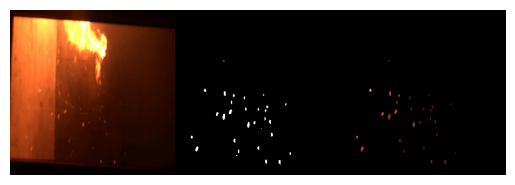

38/38 [==============================] - 87s 2s/step - loss: 0.0055 - mean_iou: 0.6362 - val_loss: 0.0036 - val_mean_iou: 0.6604
Epoch 79/100
138.png
90.png
197.png
4.png
168.png
 1/38 [..............................] - ETA: 1:13 - loss: 0.0063 - mean_iou: 0.5888128.png
159.png
81.png
33.png
100.png
 2/38 [>.............................] - ETA: 1:15 - loss: 0.0069 - mean_iou: 0.603398.png
128.png
131.png
145.png
151.png
 3/38 [=>............................] - ETA: 1:31 - loss: 0.0070 - mean_iou: 0.6166165.png
43.png
92.png
42.png
74.png
 4/38 [==>...........................] - ETA: 1:24 - loss: 0.0065 - mean_iou: 0.612489.png
92.png
106.png
148.png
40.png
 5/38 [==>...........................] - ETA: 1:16 - loss: 0.0065 - mean_iou: 0.618345.png
58.png
46.png
68.png
107.png
 6/38 [===>..........................] - ETA: 1:11 - loss: 0.0065 - mean_iou: 0.63093.png
46.png
49.png
75.png
59.png
 7/38 [====>.........................] - ETA: 1:07 - loss: 0.0062 - mean_iou: 0.631067.png
150.pn

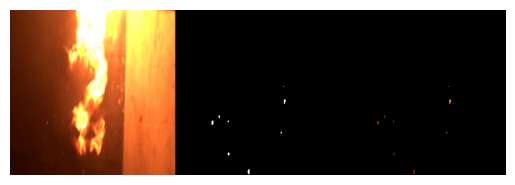

38/38 [==============================] - 87s 2s/step - loss: 0.0063 - mean_iou: 0.6213 - val_loss: 0.0063 - val_mean_iou: 0.6295
Epoch 80/100
4.png
188.png
79.png
120.png
115.png
 1/38 [..............................] - ETA: 1:15 - loss: 0.0078 - mean_iou: 0.6061157.png
122.png
179.png
13.png
180.png
 2/38 [>.............................] - ETA: 1:08 - loss: 0.0061 - mean_iou: 0.6323166.png
16.png
110.png
98.png
95.png
 3/38 [=>............................] - ETA: 1:04 - loss: 0.0053 - mean_iou: 0.635346.png
166.png
45.png
123.png
82.png
 4/38 [==>...........................] - ETA: 1:14 - loss: 0.0061 - mean_iou: 0.623658.png
73.png
172.png
61.png
59.png
 5/38 [==>...........................] - ETA: 1:16 - loss: 0.0059 - mean_iou: 0.629744.png
190.png
107.png
104.png
168.png
 6/38 [===>..........................] - ETA: 1:11 - loss: 0.0056 - mean_iou: 0.6383122.png
34.png
96.png
15.png
97.png
 7/38 [====>.........................] - ETA: 1:06 - loss: 0.0056 - mean_iou: 0.634583.png
16

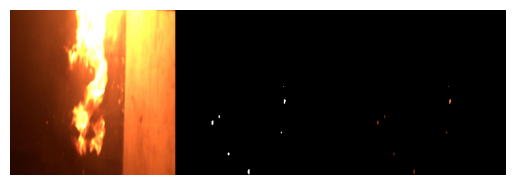

38/38 [==============================] - 90s 2s/step - loss: 0.0062 - mean_iou: 0.6146 - val_loss: 0.0060 - val_mean_iou: 0.6607
Epoch 81/100
120.png
102.png
84.png
40.png
39.png
 1/38 [..............................] - ETA: 1:16 - loss: 0.0056 - mean_iou: 0.6400172.png
13.png
133.png
139.png
167.png
 2/38 [>.............................] - ETA: 1:09 - loss: 0.0066 - mean_iou: 0.643650.png
189.png
109.png
15.png
67.png
 3/38 [=>............................] - ETA: 1:08 - loss: 0.0072 - mean_iou: 0.624317.png
199.png
164.png
19.png
157.png
 4/38 [==>...........................] - ETA: 1:05 - loss: 0.0071 - mean_iou: 0.6326100.png
137.png
169.png
168.png
89.png
 5/38 [==>...........................] - ETA: 1:07 - loss: 0.0072 - mean_iou: 0.5983172.png
183.png
98.png
159.png
184.png
 6/38 [===>..........................] - ETA: 1:11 - loss: 0.0073 - mean_iou: 0.597116.png
168.png
9.png
77.png
49.png
 7/38 [====>.........................] - ETA: 1:08 - loss: 0.0069 - mean_iou: 0.590135.png

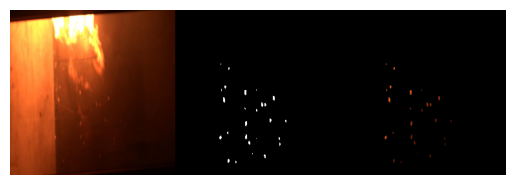

38/38 [==============================] - 84s 2s/step - loss: 0.0063 - mean_iou: 0.6186 - val_loss: 0.0051 - val_mean_iou: 0.6814
Epoch 82/100
103.png
164.png
15.png
183.png
142.png
 1/38 [..............................] - ETA: 1:56 - loss: 0.0090 - mean_iou: 0.654325.png
165.png
24.png
145.png
119.png
 2/38 [>.............................] - ETA: 1:34 - loss: 0.0075 - mean_iou: 0.6022169.png
147.png
169.png
124.png
168.png
 3/38 [=>............................] - ETA: 1:18 - loss: 0.0071 - mean_iou: 0.605919.png
35.png
11.png
84.png
169.png
 4/38 [==>...........................] - ETA: 1:12 - loss: 0.0067 - mean_iou: 0.6098135.png
34.png
38.png
165.png
3.png
 5/38 [==>...........................] - ETA: 1:08 - loss: 0.0065 - mean_iou: 0.619417.png
49.png
52.png
9.png
161.png
 6/38 [===>..........................] - ETA: 1:05 - loss: 0.0064 - mean_iou: 0.6109131.png
120.png
154.png
139.png
18.png
 7/38 [====>.........................] - ETA: 1:02 - loss: 0.0060 - mean_iou: 0.610568.png


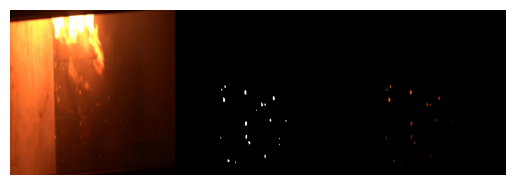

38/38 [==============================] - 93s 2s/step - loss: 0.0058 - mean_iou: 0.6286 - val_loss: 0.0038 - val_mean_iou: 0.6560
Epoch 83/100
188.png
13.png
111.png
101.png
74.png
 1/38 [..............................] - ETA: 1:16 - loss: 0.0084 - mean_iou: 0.5278199.png
60.png
123.png
59.png
60.png
 2/38 [>.............................] - ETA: 1:42 - loss: 0.0068 - mean_iou: 0.591167.png
136.png
94.png
188.png
83.png
 3/38 [=>............................] - ETA: 1:37 - loss: 0.0067 - mean_iou: 0.6116131.png
36.png
90.png
198.png
123.png
 4/38 [==>...........................] - ETA: 1:24 - loss: 0.0066 - mean_iou: 0.627937.png
26.png
45.png
23.png
141.png
 5/38 [==>...........................] - ETA: 1:16 - loss: 0.0065 - mean_iou: 0.6350110.png
3.png
1.png
58.png
72.png
 6/38 [===>..........................] - ETA: 1:12 - loss: 0.0063 - mean_iou: 0.6361192.png
10.png
161.png
54.png
36.png
 7/38 [====>.........................] - ETA: 1:07 - loss: 0.0063 - mean_iou: 0.6391112.png
1.png

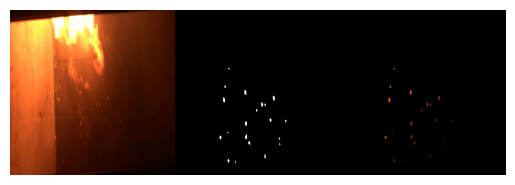

38/38 [==============================] - 86s 2s/step - loss: 0.0061 - mean_iou: 0.6309 - val_loss: 0.0056 - val_mean_iou: 0.6239
Epoch 84/100
126.png
154.png
44.png
89.png
162.png
 1/38 [..............................] - ETA: 1:14 - loss: 0.0062 - mean_iou: 0.599363.png
54.png
176.png
9.png
19.png
 2/38 [>.............................] - ETA: 1:07 - loss: 0.0055 - mean_iou: 0.641182.png
17.png
167.png
86.png
173.png
 3/38 [=>............................] - ETA: 1:06 - loss: 0.0065 - mean_iou: 0.5885148.png
42.png
21.png
83.png
55.png
 4/38 [==>...........................] - ETA: 1:16 - loss: 0.0061 - mean_iou: 0.6123126.png
54.png
53.png
163.png
91.png
 5/38 [==>...........................] - ETA: 1:17 - loss: 0.0057 - mean_iou: 0.612096.png
48.png
197.png
157.png
20.png
 6/38 [===>..........................] - ETA: 1:12 - loss: 0.0058 - mean_iou: 0.602444.png
183.png
64.png
57.png
87.png
 7/38 [====>.........................] - ETA: 1:08 - loss: 0.0056 - mean_iou: 0.6100191.png
9.png


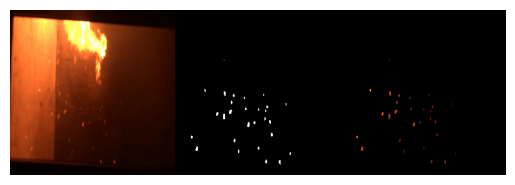

38/38 [==============================] - 88s 2s/step - loss: 0.0056 - mean_iou: 0.6306 - val_loss: 0.0063 - val_mean_iou: 0.6191
Epoch 85/100
108.png
19.png
64.png
78.png
181.png
 1/38 [..............................] - ETA: 1:12 - loss: 0.0071 - mean_iou: 0.566383.png
136.png
66.png
154.png
187.png
 2/38 [>.............................] - ETA: 1:08 - loss: 0.0065 - mean_iou: 0.6109174.png
53.png
110.png
153.png
97.png
 3/38 [=>............................] - ETA: 1:20 - loss: 0.0067 - mean_iou: 0.6282131.png
116.png
1.png
176.png
42.png
 4/38 [==>...........................] - ETA: 1:27 - loss: 0.0063 - mean_iou: 0.617653.png
100.png
46.png
136.png
3.png
 5/38 [==>...........................] - ETA: 1:29 - loss: 0.0061 - mean_iou: 0.622510.png
54.png
76.png
18.png
17.png
 6/38 [===>..........................] - ETA: 1:23 - loss: 0.0061 - mean_iou: 0.6210145.png
154.png
20.png
74.png
81.png
 7/38 [====>.........................] - ETA: 1:17 - loss: 0.0063 - mean_iou: 0.618849.png
3.png

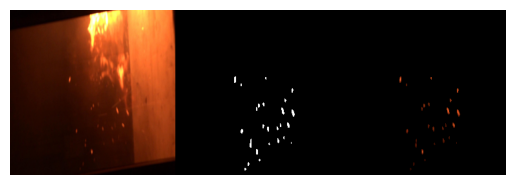

38/38 [==============================] - 87s 2s/step - loss: 0.0060 - mean_iou: 0.6296 - val_loss: 0.0079 - val_mean_iou: 0.6275
Epoch 86/100
21.png
48.png
97.png
136.png
172.png
 1/38 [..............................] - ETA: 1:48 - loss: 0.0048 - mean_iou: 0.6015130.png
138.png
26.png
191.png
147.png
 2/38 [>.............................] - ETA: 1:08 - loss: 0.0049 - mean_iou: 0.6014191.png
7.png
116.png
134.png
134.png
 3/38 [=>............................] - ETA: 1:07 - loss: 0.0058 - mean_iou: 0.6098156.png
66.png
11.png
132.png
127.png
 4/38 [==>...........................] - ETA: 1:05 - loss: 0.0059 - mean_iou: 0.6099198.png
179.png
125.png
115.png
4.png
 5/38 [==>...........................] - ETA: 1:03 - loss: 0.0059 - mean_iou: 0.613147.png
128.png
75.png
8.png
131.png
 6/38 [===>..........................] - ETA: 1:01 - loss: 0.0059 - mean_iou: 0.6164116.png
102.png
160.png
2.png
103.png
 7/38 [====>.........................] - ETA: 1:04 - loss: 0.0056 - mean_iou: 0.6194162.pn

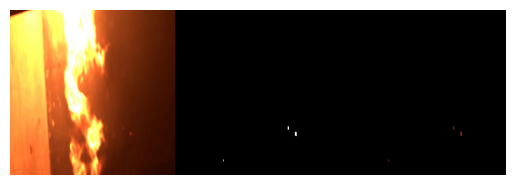

38/38 [==============================] - 85s 2s/step - loss: 0.0056 - mean_iou: 0.6274 - val_loss: 0.0062 - val_mean_iou: 0.6342
Epoch 87/100
174.png
111.png
110.png
38.png
50.png
 1/38 [..............................] - ETA: 1:16 - loss: 0.0063 - mean_iou: 0.592687.png
47.png
3.png
109.png
2.png
 2/38 [>.............................] - ETA: 1:30 - loss: 0.0056 - mean_iou: 0.639897.png
78.png
32.png
45.png
115.png
 3/38 [=>............................] - ETA: 1:36 - loss: 0.0055 - mean_iou: 0.630981.png
166.png
51.png
130.png
140.png
 4/38 [==>...........................] - ETA: 1:24 - loss: 0.0055 - mean_iou: 0.6489158.png
98.png
82.png
117.png
180.png
 5/38 [==>...........................] - ETA: 1:17 - loss: 0.0053 - mean_iou: 0.6463100.png
31.png
47.png
112.png
43.png
 6/38 [===>..........................] - ETA: 1:12 - loss: 0.0056 - mean_iou: 0.646510.png
15.png
8.png
96.png
156.png
 7/38 [====>.........................] - ETA: 1:08 - loss: 0.0058 - mean_iou: 0.6394128.png
95.png

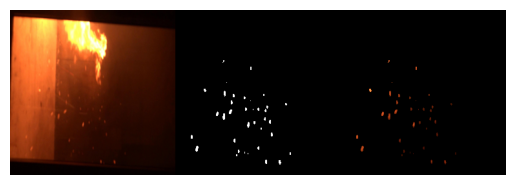

38/38 [==============================] - 90s 2s/step - loss: 0.0056 - mean_iou: 0.6412 - val_loss: 0.0064 - val_mean_iou: 0.6139
Epoch 88/100
25.png
90.png
43.png
86.png
143.png
 1/38 [..............................] - ETA: 1:17 - loss: 0.0083 - mean_iou: 0.631360.png
121.png
146.png
197.png
197.png
 2/38 [>.............................] - ETA: 1:08 - loss: 0.0067 - mean_iou: 0.6394122.png
193.png
32.png
5.png
107.png
 3/38 [=>............................] - ETA: 1:06 - loss: 0.0058 - mean_iou: 0.643835.png
116.png
189.png
133.png
147.png
 4/38 [==>...........................] - ETA: 1:13 - loss: 0.0055 - mean_iou: 0.658729.png
12.png
3.png
124.png
63.png
 5/38 [==>...........................] - ETA: 1:16 - loss: 0.0056 - mean_iou: 0.6570189.png
56.png
56.png
163.png
37.png
 6/38 [===>..........................] - ETA: 1:11 - loss: 0.0058 - mean_iou: 0.657532.png
53.png
102.png
68.png
104.png
 7/38 [====>.........................] - ETA: 1:07 - loss: 0.0061 - mean_iou: 0.656013.png
54.

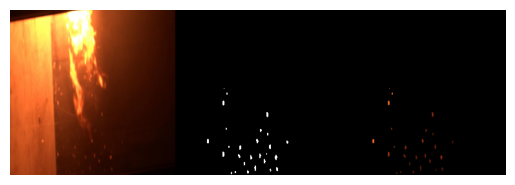

38/38 [==============================] - 87s 2s/step - loss: 0.0058 - mean_iou: 0.6503 - val_loss: 0.0045 - val_mean_iou: 0.6709
Epoch 89/100
162.png
77.png
192.png
48.png
186.png
 1/38 [..............................] - ETA: 1:14 - loss: 0.0049 - mean_iou: 0.654610.png
110.png
87.png
13.png
101.png
 2/38 [>.............................] - ETA: 1:10 - loss: 0.0049 - mean_iou: 0.6592149.png
132.png
91.png
142.png
25.png
 3/38 [=>............................] - ETA: 1:08 - loss: 0.0052 - mean_iou: 0.649677.png
199.png
148.png
139.png
70.png
 4/38 [==>...........................] - ETA: 1:05 - loss: 0.0055 - mean_iou: 0.628469.png
82.png
165.png
200.png
106.png
 5/38 [==>...........................] - ETA: 1:08 - loss: 0.0054 - mean_iou: 0.639214.png
158.png
12.png
41.png
161.png
 6/38 [===>..........................] - ETA: 1:11 - loss: 0.0053 - mean_iou: 0.64633.png
158.png
139.png
139.png
180.png
 7/38 [====>.........................] - ETA: 1:09 - loss: 0.0055 - mean_iou: 0.6429189.pn

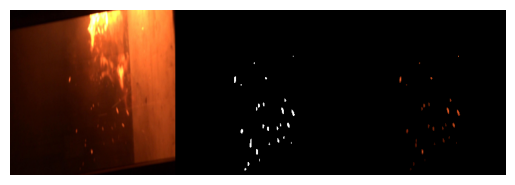

38/38 [==============================] - 87s 2s/step - loss: 0.0059 - mean_iou: 0.6270 - val_loss: 0.0050 - val_mean_iou: 0.6341
Epoch 90/100
150.png
163.png
107.png
177.png
138.png
 1/38 [..............................] - ETA: 1:47 - loss: 0.0053 - mean_iou: 0.668716.png
184.png
98.png
142.png
189.png
 2/38 [>.............................] - ETA: 1:40 - loss: 0.0050 - mean_iou: 0.653264.png
72.png
90.png
167.png
81.png
 3/38 [=>............................] - ETA: 1:22 - loss: 0.0047 - mean_iou: 0.652380.png
30.png
25.png
46.png
184.png
 4/38 [==>...........................] - ETA: 1:14 - loss: 0.0050 - mean_iou: 0.6460198.png
47.png
43.png
190.png
29.png
 5/38 [==>...........................] - ETA: 1:09 - loss: 0.0052 - mean_iou: 0.6468169.png
97.png
25.png
200.png
136.png
 6/38 [===>..........................] - ETA: 1:06 - loss: 0.0055 - mean_iou: 0.625755.png
2.png
175.png
19.png
66.png
 7/38 [====>.........................] - ETA: 1:03 - loss: 0.0056 - mean_iou: 0.6306131.png
17

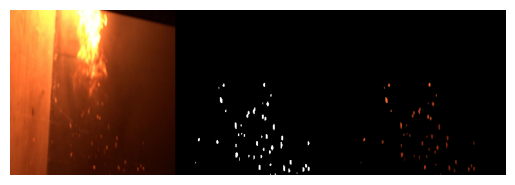

38/38 [==============================] - 86s 2s/step - loss: 0.0057 - mean_iou: 0.6296 - val_loss: 0.0059 - val_mean_iou: 0.6372
Epoch 91/100
76.png
36.png
198.png
16.png
14.png
 1/38 [..............................] - ETA: 1:14 - loss: 0.0063 - mean_iou: 0.670337.png
177.png
134.png
65.png
69.png
 2/38 [>.............................] - ETA: 1:10 - loss: 0.0055 - mean_iou: 0.6569115.png
56.png
118.png
158.png
65.png
 3/38 [=>............................] - ETA: 1:15 - loss: 0.0058 - mean_iou: 0.657484.png
93.png
162.png
23.png
132.png
 4/38 [==>...........................] - ETA: 1:22 - loss: 0.0053 - mean_iou: 0.6496128.png
89.png
181.png
116.png
157.png
 5/38 [==>...........................] - ETA: 1:18 - loss: 0.0052 - mean_iou: 0.645048.png
166.png
52.png
171.png
134.png
 6/38 [===>..........................] - ETA: 1:12 - loss: 0.0055 - mean_iou: 0.647780.png
119.png
59.png
3.png
8.png
 7/38 [====>.........................] - ETA: 1:08 - loss: 0.0054 - mean_iou: 0.64569.png
102.p

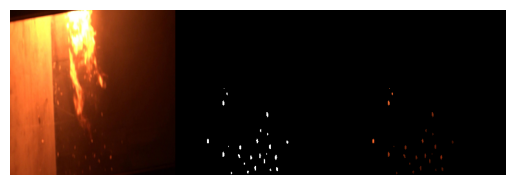

38/38 [==============================] - 90s 2s/step - loss: 0.0056 - mean_iou: 0.6449 - val_loss: 0.0052 - val_mean_iou: 0.6565
Epoch 92/100
137.png
66.png
92.png
195.png
106.png
 1/38 [..............................] - ETA: 1:16 - loss: 0.0092 - mean_iou: 0.6542167.png
101.png
94.png
9.png
107.png
 2/38 [>.............................] - ETA: 1:10 - loss: 0.0077 - mean_iou: 0.666998.png
44.png
64.png
164.png
141.png
 3/38 [=>............................] - ETA: 1:07 - loss: 0.0069 - mean_iou: 0.6512142.png
146.png
160.png
56.png
87.png
 4/38 [==>...........................] - ETA: 1:09 - loss: 0.0068 - mean_iou: 0.661541.png
19.png
170.png
120.png
10.png
 5/38 [==>...........................] - ETA: 1:15 - loss: 0.0065 - mean_iou: 0.6709120.png
13.png
149.png
59.png
168.png
 6/38 [===>..........................] - ETA: 1:13 - loss: 0.0061 - mean_iou: 0.672117.png
144.png
176.png
120.png
116.png
 7/38 [====>.........................] - ETA: 1:09 - loss: 0.0059 - mean_iou: 0.668956.png

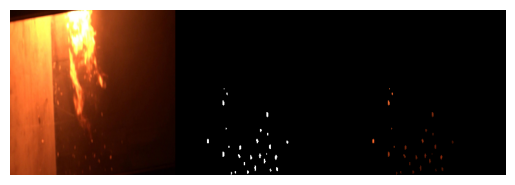

38/38 [==============================] - 86s 2s/step - loss: 0.0053 - mean_iou: 0.6516 - val_loss: 0.0045 - val_mean_iou: 0.6966
Epoch 93/100
74.png
50.png
39.png
81.png
153.png
 1/38 [..............................] - ETA: 1:42 - loss: 0.0040 - mean_iou: 0.644461.png
174.png
162.png
52.png
136.png
 2/38 [>.............................] - ETA: 1:04 - loss: 0.0041 - mean_iou: 0.656239.png
100.png
8.png
58.png
91.png
 3/38 [=>............................] - ETA: 1:06 - loss: 0.0042 - mean_iou: 0.671441.png
184.png
121.png
89.png
144.png
 4/38 [==>...........................] - ETA: 1:05 - loss: 0.0044 - mean_iou: 0.6671177.png
179.png
191.png
88.png
65.png
 5/38 [==>...........................] - ETA: 1:02 - loss: 0.0047 - mean_iou: 0.6589200.png
69.png
104.png
170.png
171.png
 6/38 [===>..........................] - ETA: 1:00 - loss: 0.0046 - mean_iou: 0.662533.png
123.png
42.png
15.png
94.png
 7/38 [====>.........................] - ETA: 1:03 - loss: 0.0048 - mean_iou: 0.66124.png
137.

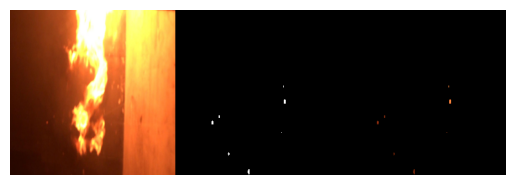

38/38 [==============================] - 88s 2s/step - loss: 0.0053 - mean_iou: 0.6532 - val_loss: 0.0057 - val_mean_iou: 0.6513
Epoch 94/100
121.png
197.png
123.png
80.png
79.png
 1/38 [..............................] - ETA: 1:38 - loss: 0.0052 - mean_iou: 0.712246.png
34.png
8.png
73.png
3.png
 2/38 [>.............................] - ETA: 1:45 - loss: 0.0054 - mean_iou: 0.681661.png
189.png
157.png
88.png
137.png
 3/38 [=>............................] - ETA: 1:28 - loss: 0.0058 - mean_iou: 0.672978.png
13.png
43.png
87.png
127.png
 4/38 [==>...........................] - ETA: 1:19 - loss: 0.0066 - mean_iou: 0.65515.png
54.png
105.png
163.png
157.png
 5/38 [==>...........................] - ETA: 1:13 - loss: 0.0061 - mean_iou: 0.64943.png
146.png
52.png
58.png
116.png
 6/38 [===>..........................] - ETA: 1:08 - loss: 0.0060 - mean_iou: 0.647247.png
192.png
63.png
198.png
106.png
 7/38 [====>.........................] - ETA: 1:05 - loss: 0.0059 - mean_iou: 0.635550.png
42.png


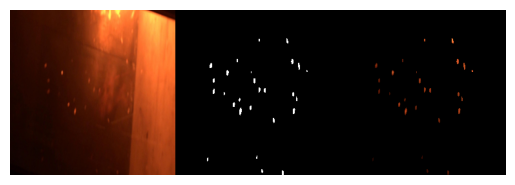

38/38 [==============================] - 87s 2s/step - loss: 0.0054 - mean_iou: 0.6495 - val_loss: 0.0065 - val_mean_iou: 0.6197
Epoch 95/100
98.png
112.png
51.png
38.png
188.png
 1/38 [..............................] - ETA: 1:15 - loss: 0.0042 - mean_iou: 0.72552.png
181.png
186.png
70.png
112.png
 2/38 [>.............................] - ETA: 1:10 - loss: 0.0041 - mean_iou: 0.7234199.png
105.png
38.png
18.png
68.png
 3/38 [=>............................] - ETA: 1:13 - loss: 0.0043 - mean_iou: 0.7098123.png
13.png
70.png
38.png
55.png
 4/38 [==>...........................] - ETA: 1:22 - loss: 0.0046 - mean_iou: 0.705944.png
137.png
88.png
138.png
130.png
 5/38 [==>...........................] - ETA: 1:18 - loss: 0.0049 - mean_iou: 0.6849121.png
53.png
188.png
119.png
140.png
 6/38 [===>..........................] - ETA: 1:13 - loss: 0.0050 - mean_iou: 0.681357.png
111.png
69.png
91.png
117.png
 7/38 [====>.........................] - ETA: 1:09 - loss: 0.0051 - mean_iou: 0.6727118.png
1

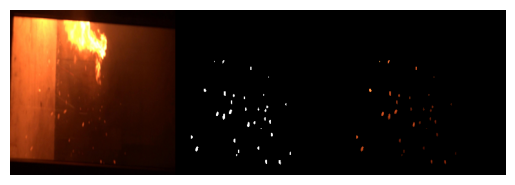

38/38 [==============================] - 89s 2s/step - loss: 0.0056 - mean_iou: 0.6597 - val_loss: 0.0064 - val_mean_iou: 0.6329
Epoch 96/100
89.png
7.png
120.png
65.png
34.png
 1/38 [..............................] - ETA: 1:18 - loss: 0.0067 - mean_iou: 0.677777.png
103.png
73.png
42.png
129.png
 2/38 [>.............................] - ETA: 1:12 - loss: 0.0059 - mean_iou: 0.664675.png
41.png
33.png
72.png
35.png
 3/38 [=>............................] - ETA: 1:10 - loss: 0.0054 - mean_iou: 0.673493.png
67.png
157.png
162.png
171.png
 4/38 [==>...........................] - ETA: 1:15 - loss: 0.0052 - mean_iou: 0.670654.png
82.png
91.png
144.png
54.png
 5/38 [==>...........................] - ETA: 1:19 - loss: 0.0054 - mean_iou: 0.66753.png
68.png
92.png
181.png
43.png
 6/38 [===>..........................] - ETA: 1:15 - loss: 0.0051 - mean_iou: 0.675258.png
31.png
175.png
110.png
42.png
 7/38 [====>.........................] - ETA: 1:10 - loss: 0.0050 - mean_iou: 0.674755.png
86.png
75.

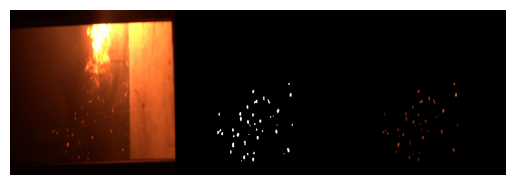

38/38 [==============================] - 88s 2s/step - loss: 0.0056 - mean_iou: 0.6555 - val_loss: 0.0060 - val_mean_iou: 0.6265
Epoch 97/100
117.png
159.png
87.png
24.png
90.png
 1/38 [..............................] - ETA: 1:16 - loss: 0.0076 - mean_iou: 0.6217104.png
3.png
108.png
102.png
169.png
 2/38 [>.............................] - ETA: 1:10 - loss: 0.0072 - mean_iou: 0.624366.png
101.png
144.png
93.png
39.png
 3/38 [=>............................] - ETA: 1:09 - loss: 0.0061 - mean_iou: 0.6346184.png
107.png
127.png
38.png
177.png
 4/38 [==>...........................] - ETA: 1:07 - loss: 0.0060 - mean_iou: 0.648644.png
17.png
106.png
127.png
197.png
 5/38 [==>...........................] - ETA: 1:06 - loss: 0.0061 - mean_iou: 0.651641.png
31.png
87.png
129.png
71.png
 6/38 [===>..........................] - ETA: 1:11 - loss: 0.0057 - mean_iou: 0.6714176.png
174.png
90.png
148.png
20.png
 7/38 [====>.........................] - ETA: 1:10 - loss: 0.0058 - mean_iou: 0.673713.png


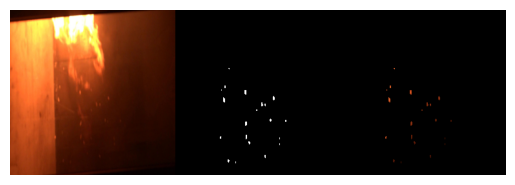

38/38 [==============================] - 97s 3s/step - loss: 0.0054 - mean_iou: 0.6581 - val_loss: 0.0065 - val_mean_iou: 0.6127
Epoch 98/100
183.png
33.png
137.png
114.png
144.png
 1/38 [..............................] - ETA: 1:17 - loss: 0.0057 - mean_iou: 0.568832.png
112.png
111.png
10.png
108.png
 2/38 [>.............................] - ETA: 1:10 - loss: 0.0062 - mean_iou: 0.6289174.png
18.png
38.png
136.png
121.png
 3/38 [=>............................] - ETA: 1:26 - loss: 0.0062 - mean_iou: 0.6125122.png
154.png
33.png
123.png
58.png
 4/38 [==>...........................] - ETA: 1:27 - loss: 0.0063 - mean_iou: 0.6339164.png
103.png
115.png
46.png
183.png
 5/38 [==>...........................] - ETA: 1:20 - loss: 0.0061 - mean_iou: 0.6473145.png
89.png
13.png
21.png
107.png
 6/38 [===>..........................] - ETA: 1:14 - loss: 0.0059 - mean_iou: 0.6560174.png
72.png
166.png
44.png
134.png
 7/38 [====>.........................] - ETA: 1:10 - loss: 0.0057 - mean_iou: 0.664744.

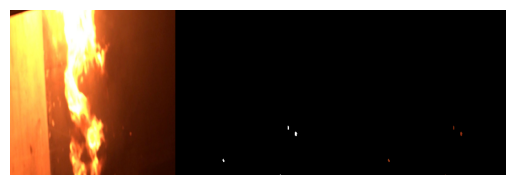

38/38 [==============================] - 89s 2s/step - loss: 0.0056 - mean_iou: 0.6599 - val_loss: 0.0047 - val_mean_iou: 0.6667
Epoch 99/100
63.png
163.png
162.png
168.png
31.png
 1/38 [..............................] - ETA: 1:18 - loss: 0.0050 - mean_iou: 0.685424.png
84.png
42.png
14.png
32.png
 2/38 [>.............................] - ETA: 1:09 - loss: 0.0051 - mean_iou: 0.6624189.png
81.png
68.png
104.png
73.png
 3/38 [=>............................] - ETA: 1:07 - loss: 0.0053 - mean_iou: 0.6678101.png
82.png
34.png
199.png
32.png
 4/38 [==>...........................] - ETA: 1:15 - loss: 0.0050 - mean_iou: 0.6619105.png
200.png
133.png
136.png
159.png
 5/38 [==>...........................] - ETA: 1:18 - loss: 0.0046 - mean_iou: 0.666444.png
29.png
7.png
94.png
136.png
 6/38 [===>..........................] - ETA: 1:13 - loss: 0.0054 - mean_iou: 0.654036.png
54.png
196.png
124.png
168.png
 7/38 [====>.........................] - ETA: 1:09 - loss: 0.0057 - mean_iou: 0.655255.png
180

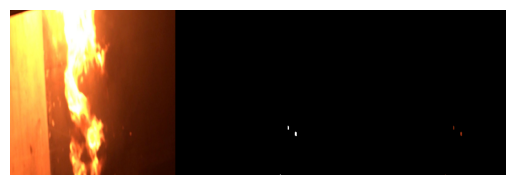

38/38 [==============================] - 90s 2s/step - loss: 0.0059 - mean_iou: 0.6542 - val_loss: 0.0043 - val_mean_iou: 0.6714
Epoch 100/100
168.png
76.png
21.png
23.png
132.png
 1/38 [..............................] - ETA: 1:19 - loss: 0.0037 - mean_iou: 0.7190170.png
37.png
115.png
38.png
83.png
 2/38 [>.............................] - ETA: 1:11 - loss: 0.0049 - mean_iou: 0.690571.png
73.png
146.png
88.png
67.png
 3/38 [=>............................] - ETA: 1:09 - loss: 0.0055 - mean_iou: 0.6766177.png
162.png
153.png
192.png
67.png
 4/38 [==>...........................] - ETA: 1:07 - loss: 0.0056 - mean_iou: 0.643838.png
53.png
98.png
168.png
36.png
 5/38 [==>...........................] - ETA: 1:14 - loss: 0.0058 - mean_iou: 0.6485117.png
168.png
162.png
56.png
149.png
 6/38 [===>..........................] - ETA: 1:13 - loss: 0.0057 - mean_iou: 0.6479145.png
177.png
116.png
43.png
51.png
 7/38 [====>.........................] - ETA: 1:10 - loss: 0.0056 - mean_iou: 0.641533.png


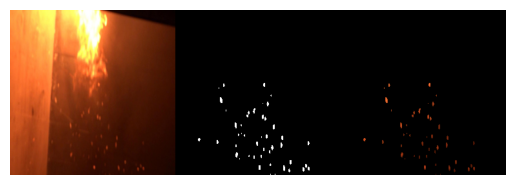

38/38 [==============================] - 88s 2s/step - loss: 0.0057 - mean_iou: 0.6390 - val_loss: 0.0042 - val_mean_iou: 0.6883


In [19]:
model = unet()

train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator,
                    epochs = 100, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 1)

# Continue the training

In [20]:
# save model (weights, architecture, optimizer state)
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
from keras.models import load_model

model_continue = load_model('my_model.h5', compile=False)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])

In [ ]:
model.load_weights('unet.h5')

train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator,
                    epochs = 100, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 1)


# Prediction

1/1 [==============================] - 0s 78ms/step


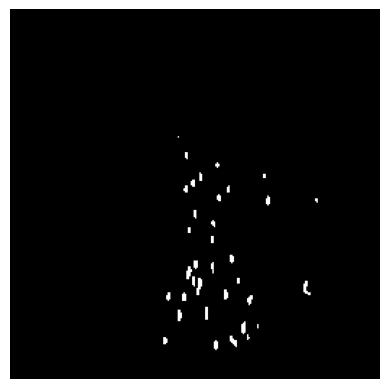

<Figure size 640x480 with 0 Axes>

In [19]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#show the mask and the segmented image
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(msk)
plt.show()
plt.savefig('mask.png')